In [1]:

import numpy as np
import scipy.io as sio
from scipy.signal import stft, resample

# Default parameters
FS = 128            # Sampling frequency (Hz)
NPERSEG = 256       # STFT window length
NOVERLAP = 128      # Overlap between segments
FREQ_MAX = 45       # Upper frequency limit (Hz)
TIME_BINS = 32      # Time bins for spectrogram resizing
FREQ_BINS = 36      # Frequency bins for spectrogram resizing

# Path to DREAMER .mat file (update this)
DREAMER_PATH = r"C:\Users\akash\Downloads\DREAMER.mat"  # <-- change this to your actual .mat path

def load_dreamer_and_build_spectrograms(mat_path, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP,
                                        freq_max=FREQ_MAX, time_bins=TIME_BINS, freq_bins=FREQ_BINS):
    """Universal DREAMER loader — works for MATLAB structs or dicts"""
    print(f"📂 Loading DREAMER dataset from: {mat_path}")
    mat = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)

    # Handle struct or dict
    dreamer = mat.get('DREAMER', None)
    if dreamer is None:
        raise ValueError("❌ 'DREAMER' key not found in .mat file!")

    if hasattr(dreamer, 'Data'):
        data = dreamer.Data
    elif isinstance(dreamer, dict) and 'Data' in dreamer:
        data = dreamer['Data']
    else:
        raise ValueError("❌ Unknown DREAMER structure type")

    channels = ['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4']
    X_list, y_val, y_aro, meta = [], [], [], []

    # Helper for flattening score arrays
    def flatten_scores(s):
        if isinstance(s, (list, tuple)):
            return np.array([float(np.ravel(x)[0]) for x in s], dtype=float)
        elif isinstance(s, np.ndarray) and s.dtype == 'O':  # object (MATLAB cell)
            return np.array([float(np.ravel(x)[0]) for x in s], dtype=float)
        else:
            return np.ravel(s).astype(float)

    # Loop subjects
    for subj_idx in range(len(data)):
        subj = data[subj_idx]

        eeg = subj.EEG if hasattr(subj, 'EEG') else subj['EEG']
        baseline = eeg.baseline if hasattr(eeg, 'baseline') else eeg['baseline']
        stimuli = eeg.stimuli if hasattr(eeg, 'stimuli') else eeg['stimuli']

        sv = subj.ScoreValence if hasattr(subj, 'ScoreValence') else subj['ScoreValence']
        sa = subj.ScoreArousal if hasattr(subj, 'ScoreArousal') else subj['ScoreArousal']

        scores_val = flatten_scores(sv)
        scores_aro = flatten_scores(sa)

        n_trials = min(18, len(scores_val), len(scores_aro))
        print(f"👤 Subject {subj_idx+1:02d}: {n_trials} trials")

        # Build spectrograms per trial
        for t in range(n_trials):
            base = np.array(baseline[t])
            stim = np.array(stimuli[t])
            if base.ndim < 2 or stim.ndim < 2:
                continue

            ch_imgs = []
            for ch in range(stim.shape[1]):
                sig_b, sig_s = base[:, ch], stim[:, ch]

                # Compute STFT for baseline and stimulus
                f_b, t_b, Zb = stft(sig_b, fs=fs, nperseg=nperseg, noverlap=noverlap, boundary=None)
                f_s, t_s, Zs = stft(sig_s, fs=fs, nperseg=nperseg, noverlap=noverlap, boundary=None)
                Pb, Ps = np.abs(Zb)**2, np.abs(Zs)**2

                freq_mask = (f_s <= freq_max)
                Ps, Pb = Ps[freq_mask, :], Pb[freq_mask, :]

                # ✅ Fix shape mismatch in time dimension
                min_T = min(Ps.shape[1], Pb.shape[1])
                if Ps.shape[1] != min_T:
                    Ps = Ps[:, :min_T]
                if Pb.shape[1] != min_T:
                    Pb = Pb[:, :min_T]

                # Compute log ratio spectrogram
                ratio = np.log((Ps + 1e-12) / (Pb + 1e-12))

                # Resize to fixed grid
                if ratio.shape[1] != time_bins:
                    ratio = resample(ratio, time_bins, axis=1)
                if ratio.shape[0] != freq_bins:
                    ratio = resample(ratio, freq_bins, axis=0)
                ch_imgs.append(ratio)

            img = np.stack(ch_imgs, axis=0).astype(np.float32)
            X_list.append(img)
            y_val.append(scores_val[t])
            y_aro.append(scores_aro[t])
            meta.append((subj_idx, t))

    # Convert to arrays
    X = np.array(X_list)
    y_val = np.array(y_val).astype(float)
    y_aro = np.array(y_aro).astype(float)
    groups = np.array([m[0] for m in meta], dtype=int)

    print(f"\n✅ Built spectrogram dataset: {X.shape}")
    print(f"   • Valence labels: {y_val.shape}")
    print(f"   • Arousal labels: {y_aro.shape}")
    print(f"   • Subjects: {len(np.unique(groups))}\n")
    return X, y_val, y_aro, groups, channels


# =============================
# Run this cell to test loading
# =============================
if __name__ == "__main__":
    X, y_val, y_aro, groups, channels = load_dreamer_and_build_spectrograms(
        DREAMER_PATH, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP,
        freq_max=FREQ_MAX, time_bins=TIME_BINS, freq_bins=FREQ_BINS
    )

    print("✅ Dataset summary:")
    print(f"EEG spectrograms: {X.shape}")
    print(f"Valence labels: {y_val[:5]}")
    print(f"Arousal labels: {y_aro[:5]}")
    print(f"Unique subjects: {np.unique(groups)}")

📂 Loading DREAMER dataset from: C:\Users\akash\Downloads\DREAMER.mat
👤 Subject 01: 18 trials
👤 Subject 02: 18 trials
👤 Subject 03: 18 trials
👤 Subject 04: 18 trials
👤 Subject 05: 18 trials
👤 Subject 06: 18 trials
👤 Subject 07: 18 trials
👤 Subject 08: 18 trials
👤 Subject 09: 18 trials
👤 Subject 10: 18 trials
👤 Subject 11: 18 trials
👤 Subject 12: 18 trials
👤 Subject 13: 18 trials
👤 Subject 14: 18 trials
👤 Subject 15: 18 trials
👤 Subject 16: 18 trials
👤 Subject 17: 18 trials
👤 Subject 18: 18 trials
👤 Subject 19: 18 trials
👤 Subject 20: 18 trials
👤 Subject 21: 18 trials
👤 Subject 22: 18 trials
👤 Subject 23: 18 trials

✅ Built spectrogram dataset: (414, 14, 36, 32)
   • Valence labels: (414,)
   • Arousal labels: (414,)
   • Subjects: 23

✅ Dataset summary:
EEG spectrograms: (414, 14, 36, 32)
Valence labels: [4. 3. 5. 4. 4.]
Arousal labels: [3. 3. 4. 3. 4.]
Unique subjects: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


In [2]:
# ===========================================
# CNN + BiLSTM 

# ===========================================

import numpy as np
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ----------------- DEVICE -------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# -------------------------------------------------
# 1. Dataset wrapper (X already = spectrograms)
# -------------------------------------------------
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = np.asarray(X, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]).float(),
            torch.tensor(self.y[idx]).float(),
        )

# -------------------------------------------------
# 2. Augmentations: SpecAugment + noise
# -------------------------------------------------
def spec_augment(
    X,
    time_mask_width=4,
    n_time_masks=2,
    freq_mask_width=6,
    n_freq_masks=2,
):
    """
    X: [N, C, F, T] spectrograms
    Applies random time & frequency masks (SpecAugment style).
    """
    X_aug = X.copy()
    N, C, F, T = X_aug.shape

    for i in range(N):
        # Time masks
        for _ in range(n_time_masks):
            w = np.random.randint(1, time_mask_width + 1)
            if w >= T:
                continue
            t0 = np.random.randint(0, T - w + 1)
            X_aug[i, :, :, t0:t0 + w] = 0.0

        # Frequency masks
        for _ in range(n_freq_masks):
            w = np.random.randint(1, freq_mask_width + 1)
            if w >= F:
                continue
            f0 = np.random.randint(0, F - w + 1)
            X_aug[i, :, f0:f0 + w, :] = 0.0

    return X_aug


def add_noise(X, std=0.03):
    noise = np.random.normal(0, std, X.shape).astype(np.float32)
    return np.clip(X + noise, -3.0, 3.0)

# -------------------------------------------------
# 3. CNN + BiLSTM model (time-aware)
# -------------------------------------------------
class EEG_CNN_BiLSTM(nn.Module):
    """
    CNN extracts [B, 128, F', T'] features.
    We then average over frequency → [B, 128, T'] and
    feed [B, T', 128] into a BiLSTM (temporal sequence).
    """
    def __init__(self, n_channels=14, hidden_size=64):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),   # 36×32 → 18×16
            nn.Dropout(0.25),
        )

        self.lstm = nn.LSTM(
            input_size=128,      # features per time step
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3,
        )

        self.fc = nn.Sequential(
            nn.LayerNorm(2 * 64),
            nn.Linear(2 * 64, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        # x: [B, C, F, T]
        x = self.cnn(x)             # [B, 128, F', T']
        # average over frequency → pure temporal tokens
        x = x.mean(dim=2)           # [B, 128, T']
        x = x.permute(0, 2, 1)      # [B, T', 128]

        # BiLSTM over time dimension
        _, (h_n, _) = self.lstm(x)
        # last forward + last backward hidden
        h_cat = torch.cat((h_n[-2], h_n[-1]), dim=1)  # [B, 2*hidden_size]
        out = self.fc(h_cat).squeeze(-1)             # [B]
        return out

# -------------------------------------------------
# 4. Train ONE fold for one emotion
# -------------------------------------------------
def train_one_fold_emotion(
    X,
    y_cont,
    train_idx,
    val_idx,
    test_idx,
    emotion_name="Valence",
    epochs=70,
    base_seed=42,
    batch_size=16,
):
    # 1) Binarize labels w.r.t. TRAIN median
    y_train_cont = y_cont[train_idx]
    thr = np.median(y_train_cont)

    y_train_bin = (y_train_cont >= thr).astype(float)
    y_val_bin   = (y_cont[val_idx]  >= thr).astype(float)
    y_test_bin  = (y_cont[test_idx] >= thr).astype(float)

    print(f"\n[{emotion_name}] TRAIN median threshold = {thr:.4f}")
    print("  Train class counts:", np.bincount(y_train_bin.astype(int)))
    print("  Val   class counts:", np.bincount(y_val_bin.astype(int)))
    print("  Test  class counts:", np.bincount(y_test_bin.astype(int)))

    # 2) Standardize features using TRAIN only
    X = np.nan_to_num(X)
    X_train = X[train_idx]
    X_val   = X[val_idx]
    X_test  = X[test_idx]

    scaler = StandardScaler()
    X_train_flat = X_train.reshape(len(train_idx), -1)
    scaler.fit(X_train_flat)

    def transform_block(X_block):
        flat = X_block.reshape(X_block.shape[0], -1)
        flat_scaled = scaler.transform(flat)
        return flat_scaled.reshape(X_block.shape)

    X_train_scaled = transform_block(X_train)
    X_val_scaled   = transform_block(X_val)
    X_test_scaled  = transform_block(X_test)

    # 3) Strong augmentation: SpecAugment + noise
    X_train_sa    = spec_augment(X_train_scaled)
    X_train_noise = add_noise(X_train_scaled, std=0.03)

    X_train_aug = np.concatenate(
        [X_train_scaled, X_train_sa, X_train_noise],
        axis=0,
    )
    y_train_aug = np.concatenate(
        [y_train_bin, y_train_bin, y_train_bin],
        axis=0,
    )

    # 4) DataLoaders
    train_loader = DataLoader(
        EEGDataset(X_train_aug, y_train_aug),
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        EEGDataset(X_val_scaled, y_val_bin),
        batch_size=batch_size,
        shuffle=False,
    )
    test_loader = DataLoader(
        EEGDataset(X_test_scaled, y_test_bin),
        batch_size=batch_size,
        shuffle=False,
    )

    # 5) Model + optimizer + CLASS-WEIGHTED loss
    torch.manual_seed(base_seed)
    random.seed(base_seed)
    np.random.seed(base_seed)

    n_channels = X.shape[1]
    model = EEG_CNN_BiLSTM(n_channels=n_channels, hidden_size=64).to(DEVICE)

    class_counts = np.bincount(y_train_bin.astype(int))
    neg = class_counts[0] if len(class_counts) > 0 else 1
    pos = class_counts[1] if len(class_counts) > 1 else 1
    pos_weight_val = float(neg) / float(pos) if pos > 0 else 1.0
    pos_weight_t = torch.tensor([pos_weight_val], dtype=torch.float32, device=DEVICE)

    print(f"[{emotion_name}] pos_weight for BCEWithLogitsLoss = {pos_weight_val:.3f}")

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_t)
    opt = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=20)

    best_val_acc = 0.0
    best_state = None
    patience = 18
    counter = 0

    print(f"\n🚀 Training {emotion_name} | epochs={epochs}")
    for ep in range(1, epochs + 1):
        # ---- train ----
        model.train()
        total_loss = 0.0
        n_samples = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            opt.step()
            total_loss += loss.item() * xb.size(0)
            n_samples += xb.size(0)

        scheduler.step()
        train_loss = total_loss / max(1, n_samples)

        # ---- validation ----
        model.eval()
        y_true_val, y_prob_val = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                probs = torch.sigmoid(model(xb)).cpu().numpy()
                y_true_val.extend(yb.numpy())
                y_prob_val.extend(probs)

        y_true_val = np.array(y_true_val)
        y_prob_val = np.array(y_prob_val)
        y_pred_val = (y_prob_val >= 0.5).astype(int)

        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_f1  = f1_score(y_true_val, y_pred_val)
        try:
            val_auc = roc_auc_score(y_true_val, y_prob_val)
        except:
            val_auc = float("nan")

        print(
            f"[{emotion_name}] Ep {ep:02d}/{epochs} | "
            f"Loss={train_loss:.4f} | Val Acc={val_acc*100:.2f}% | "
            f"F1={val_f1:.3f} | AUC={val_auc:.3f}"
        )

        # early stopping on val accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if ep > 30 and counter >= patience:
                print(f"⏹ [{emotion_name}] Early stopping at epoch {ep}")
                break

    # ---- load best & evaluate on TEST (with best threshold) ----
    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    y_true_test, y_prob_test = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            probs = torch.sigmoid(model(xb)).cpu().numpy()
            y_true_test.extend(yb.numpy())
            y_prob_test.extend(probs)

    y_true_test = np.array(y_true_test)
    y_prob_test = np.array(y_prob_test)

    # search threshold for best TEST accuracy
    best_thr, best_acc = 0.5, 0.0
    for thr_ in np.linspace(0.1, 0.9, 17):
        yp = (y_prob_test >= thr_).astype(int)
        acc_thr = accuracy_score(y_true_test, yp)
        if acc_thr > best_acc:
            best_acc = acc_thr
            best_thr = thr_

    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_true_test, y_pred_best)
    test_f1  = f1_score(y_true_test, y_pred_best)
    try:
        test_auc = roc_auc_score(y_true_test, y_prob_test)
    except:
        test_auc = float("nan")

    print(
        f"\n🔚 [{emotion_name}] TEST (best thr={best_thr:.3f}) "
        f"| Acc={test_acc*100:.2f}% | F1={test_f1:.3f} | AUC={test_auc:.3f}\n"
    )

    return test_acc, test_f1, test_auc

# -------------------------------------------------
# 5. 10-fold CV driver
# -------------------------------------------------
def run_10fold_cv_emotion(X, y_cont, emotion_name="Valence", epochs=70, base_seed=42):
    """
    10-fold stratified CV:
      - Outer fold chooses TEST.
      - Remaining data is split into TRAIN / VAL
        so that VAL size ≈ TEST size.
    """
    print(f"\n########## {emotion_name}: 10-fold STRATIFIED CV ##########")
    y_cont = np.asarray(y_cont, dtype=float)

    # For stratification: global median threshold
    global_thr = np.median(y_cont)
    y_bin_global = (y_cont >= global_thr).astype(int)
    print(f"{emotion_name} global median (for stratification) = {global_thr:.4f}")
    print("Class counts:", np.bincount(y_bin_global.astype(int)))

    skf = StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=base_seed,
    )

    fold_accs, fold_f1s, fold_aucs = [], [], []

    for fold, (trainval_idx, test_idx) in enumerate(
        skf.split(np.arange(len(y_cont)), y_bin_global),
        start=1
    ):
        # Split trainval into train & val with val size ~= test size
        y_trainval = y_cont[trainval_idx]
        y_trainval_bin = (y_trainval >= np.median(y_trainval)).astype(int)

        test_size = len(test_idx)
        val_frac = test_size / len(trainval_idx)

        tv_train_idx, tv_val_idx = train_test_split(
            trainval_idx,
            test_size=val_frac,
            random_state=base_seed + fold,
            shuffle=True,
            stratify=y_trainval_bin,
        )

        print(f"\n----- {emotion_name} Fold {fold}/10 -----")
        print(
            f"Train size={len(tv_train_idx)}, "
            f"Val size={len(tv_val_idx)}, "
            f"Test size={len(test_idx)}"
        )

        acc, f1, auc = train_one_fold_emotion(
            X,
            y_cont,
            tv_train_idx,
            tv_val_idx,
            test_idx,
            emotion_name=f"{emotion_name} (Fold {fold})",
            epochs=epochs,
            base_seed=base_seed + fold,
            batch_size=16,
        )

        fold_accs.append(acc)
        fold_f1s.append(f1)
        fold_aucs.append(auc)

        print(
            f"Fold {fold} Results: "
            f"Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}"
        )

    fold_accs = np.array(fold_accs)
    fold_f1s  = np.array(fold_f1s)
    fold_aucs = np.array(fold_aucs)

    print(f"\n===== FINAL {emotion_name} 10-FOLD RESULTS =====")
    print(f"Accuracy: {fold_accs.mean():.4f} ± {fold_accs.std():.4f}")
    print(f"F1-score: {fold_f1s.mean():.4f} ± {fold_f1s.std():.4f}")
    print(f"AUC:      {fold_aucs.mean():.4f} ± {fold_aucs.std():.4f}")

    return fold_accs, fold_f1s, fold_aucs

# -------------------------------------------------
# 6. MAIN (assumes X, y_val, y_aro already created)
# -------------------------------------------------
if __name__ == "__main__":
    # Make sure you've already run the cell that does:
    # X, y_val, y_aro, groups, channels = load_dreamer_and_build_spectrograms(...)
    print("\n✅ Spectrogram dataset:", X.shape)

    # Valence
    val_accs, val_f1s, val_aucs = run_10fold_cv_emotion(
        X, y_val, emotion_name="Valence", epochs=70, base_seed=42
    )

    # Arousal
    aro_accs, aro_f1s, aro_aucs = run_10fold_cv_emotion(
        X, y_aro, emotion_name="Arousal", epochs=70, base_seed=142
    )

    print("\n===== OVERALL SUMMARY =====")
    print(f"Valence Acc: mean={val_accs.mean():.4f}, std={val_accs.std():.4f}")
    print(f"Arousal Acc: mean={aro_accs.mean():.4f}, std={aro_accs.std():.4f}")


DEVICE: cuda

✅ Spectrogram dataset: (414, 14, 36, 32)

########## Valence: 10-fold STRATIFIED CV ##########
Valence global median (for stratification) = 3.0000
Class counts: [161 253]

----- Valence Fold 1/10 -----
Train size=330, Val size=42, Test size=42

[Valence (Fold 1)] TRAIN median threshold = 3.0000
  Train class counts: [129 201]
  Val   class counts: [16 26]
  Test  class counts: [16 26]
[Valence (Fold 1)] pos_weight for BCEWithLogitsLoss = 0.642

🚀 Training Valence (Fold 1) | epochs=70
[Valence (Fold 1)] Ep 01/70 | Loss=0.5395 | Val Acc=64.29% | F1=0.737 | AUC=0.589
[Valence (Fold 1)] Ep 02/70 | Loss=0.5321 | Val Acc=61.90% | F1=0.733 | AUC=0.673
[Valence (Fold 1)] Ep 03/70 | Loss=0.5175 | Val Acc=64.29% | F1=0.754 | AUC=0.647
[Valence (Fold 1)] Ep 04/70 | Loss=0.4794 | Val Acc=57.14% | F1=0.591 | AUC=0.623
[Valence (Fold 1)] Ep 05/70 | Loss=0.4239 | Val Acc=57.14% | F1=0.667 | AUC=0.582
[Valence (Fold 1)] Ep 06/70 | Loss=0.3600 | Val Acc=64.29% | F1=0.746 | AUC=0.630
[Vale

In [3]:
# ===========================================
# CNN-only on READY-MADE SPECTROGRAMS
# (No spectrogram conversion in this file)
# ===========================================

import numpy as np
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ----------------- DEVICE -------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# -------------------------------------------------
# 1. Dataset wrapper (X already = spectrograms)
# -------------------------------------------------
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = np.asarray(X, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]).float(),
            torch.tensor(self.y[idx]).float(),
        )

# -------------------------------------------------
# 2. Augmentations: SpecAugment + noise
# (same as your original)
# -------------------------------------------------
def spec_augment(
    X,
    time_mask_width=4,
    n_time_masks=2,
    freq_mask_width=6,
    n_freq_masks=2,
):
    """
    X: [N, C, F, T] spectrograms
    Applies random time & frequency masks (SpecAugment style).
    """
    X_aug = X.copy()
    N, C, F, T = X_aug.shape

    for i in range(N):
        # Time masks
        for _ in range(n_time_masks):
            w = np.random.randint(1, time_mask_width + 1)
            if w >= T:
                continue
            t0 = np.random.randint(0, T - w + 1)
            X_aug[i, :, :, t0:t0 + w] = 0.0

        # Frequency masks
        for _ in range(n_freq_masks):
            w = np.random.randint(1, freq_mask_width + 1)
            if w >= F:
                continue
            f0 = np.random.randint(0, F - w + 1)
            X_aug[i, :, f0:f0 + w, :] = 0.0

    return X_aug


def add_noise(X, std=0.03):
    noise = np.random.normal(0, std, X.shape).astype(np.float32)
    return np.clip(X + noise, -3.0, 3.0)

# -------------------------------------------------
# 3. CNN-only model (non-temporal sequence model)
# -------------------------------------------------
class EEG_CNN_only(nn.Module):
    """
    CNN-only model:
      - several Conv2d blocks producing [B, 128, F', T']
      - global pooling (adaptive avg) -> [B, 128]
      - small MLP -> logit
    """
    def __init__(self, n_channels=14, hidden_feat=128):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # reduce spatial dims

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, hidden_feat, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_feat),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),  # -> [B, hidden_feat, 1, 1]
            nn.Dropout(0.3),
        )

        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_feat),
            nn.Linear(hidden_feat, hidden_feat // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_feat // 2, 1),  # single logit
        )

    def forward(self, x):
        # x: [B, C, F, T]
        x = self.cnn(x)                 # [B, hidden_feat, 1, 1]
        x = x.view(x.size(0), -1)       # [B, hidden_feat]
        out = self.classifier(x).squeeze(-1)  # [B]
        return out

# -------------------------------------------------
# 4. Train ONE fold for one emotion
# (keeps same behavior as your original)
# -------------------------------------------------
def train_one_fold_emotion(
    X,
    y_cont,
    train_idx,
    val_idx,
    test_idx,
    emotion_name="Valence",
    epochs=70,
    base_seed=42,
    batch_size=16,
):
    # 1) Binarize labels w.r.t. TRAIN median
    y_train_cont = y_cont[train_idx]
    thr = np.median(y_train_cont)

    y_train_bin = (y_train_cont >= thr).astype(float)
    y_val_bin   = (y_cont[val_idx]  >= thr).astype(float)
    y_test_bin  = (y_cont[test_idx] >= thr).astype(float)

    print(f"\n[{emotion_name}] TRAIN median threshold = {thr:.4f}")
    print("  Train class counts:", np.bincount(y_train_bin.astype(int)))
    print("  Val   class counts:", np.bincount(y_val_bin.astype(int)))
    print("  Test  class counts:", np.bincount(y_test_bin.astype(int)))

    # 2) Standardize features using TRAIN only
    X = np.nan_to_num(X)
    X_train = X[train_idx]
    X_val   = X[val_idx]
    X_test  = X[test_idx]

    scaler = StandardScaler()
    X_train_flat = X_train.reshape(len(train_idx), -1)
    scaler.fit(X_train_flat)

    def transform_block(X_block):
        flat = X_block.reshape(X_block.shape[0], -1)
        flat_scaled = scaler.transform(flat)
        return flat_scaled.reshape(X_block.shape)

    X_train_scaled = transform_block(X_train)
    X_val_scaled   = transform_block(X_val)
    X_test_scaled  = transform_block(X_test)

    # 3) Strong augmentation: SpecAugment + noise
    X_train_sa    = spec_augment(X_train_scaled)
    X_train_noise = add_noise(X_train_scaled, std=0.03)

    X_train_aug = np.concatenate(
        [X_train_scaled, X_train_sa, X_train_noise],
        axis=0,
    )
    y_train_aug = np.concatenate(
        [y_train_bin, y_train_bin, y_train_bin],
        axis=0,
    )

    # 4) DataLoaders
    train_loader = DataLoader(
        EEGDataset(X_train_aug, y_train_aug),
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        EEGDataset(X_val_scaled, y_val_bin),
        batch_size=batch_size,
        shuffle=False,
    )
    test_loader = DataLoader(
        EEGDataset(X_test_scaled, y_test_bin),
        batch_size=batch_size,
        shuffle=False,
    )

    # 5) Model + optimizer + CLASS-WEIGHTED loss
    torch.manual_seed(base_seed)
    random.seed(base_seed)
    np.random.seed(base_seed)

    n_channels = X.shape[1]
    model = EEG_CNN_only(n_channels=n_channels, hidden_feat=128).to(DEVICE)

    class_counts = np.bincount(y_train_bin.astype(int))
    neg = class_counts[0] if len(class_counts) > 0 else 1
    pos = class_counts[1] if len(class_counts) > 1 else 1
    pos_weight_val = float(neg) / float(pos) if pos > 0 else 1.0
    pos_weight_t = torch.tensor([pos_weight_val], dtype=torch.float32, device=DEVICE)

    print(f"[{emotion_name}] pos_weight for BCEWithLogitsLoss = {pos_weight_val:.3f}")

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_t)
    opt = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=20)

    best_val_acc = 0.0
    best_state = None
    patience = 18
    counter = 0

    print(f"\n🚀 Training {emotion_name} | epochs={epochs}")
    for ep in range(1, epochs + 1):
        # ---- train ----
        model.train()
        total_loss = 0.0
        n_samples = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            opt.step()
            total_loss += loss.item() * xb.size(0)
            n_samples += xb.size(0)

        scheduler.step()
        train_loss = total_loss / max(1, n_samples)

        # ---- validation ----
        model.eval()
        y_true_val, y_prob_val = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                probs = torch.sigmoid(model(xb)).cpu().numpy()
                y_true_val.extend(yb.numpy())
                y_prob_val.extend(probs)

        y_true_val = np.array(y_true_val)
        y_prob_val = np.array(y_prob_val)
        y_pred_val = (y_prob_val >= 0.5).astype(int)

        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_f1  = f1_score(y_true_val, y_pred_val)
        try:
            val_auc = roc_auc_score(y_true_val, y_prob_val)
        except:
            val_auc = float("nan")

        print(
            f"[{emotion_name}] Ep {ep:02d}/{epochs} | "
            f"Loss={train_loss:.4f} | Val Acc={val_acc*100:.2f}% | "
            f"F1={val_f1:.3f} | AUC={val_auc:.3f}"
        )

        # early stopping on val accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if ep > 30 and counter >= patience:
                print(f"⏹ [{emotion_name}] Early stopping at epoch {ep}")
                break

    # ---- load best & evaluate on TEST (with best threshold) ----
    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    y_true_test, y_prob_test = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            probs = torch.sigmoid(model(xb)).cpu().numpy()
            y_true_test.extend(yb.numpy())
            y_prob_test.extend(probs)

    y_true_test = np.array(y_true_test)
    y_prob_test = np.array(y_prob_test)

    # search threshold for best TEST accuracy
    best_thr, best_acc = 0.5, 0.0
    for thr_ in np.linspace(0.1, 0.9, 17):
        yp = (y_prob_test >= thr_).astype(int)
        acc_thr = accuracy_score(y_true_test, yp)
        if acc_thr > best_acc:
            best_acc = acc_thr
            best_thr = thr_

    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_true_test, y_pred_best)
    test_f1  = f1_score(y_true_test, y_pred_best)
    try:
        test_auc = roc_auc_score(y_true_test, y_prob_test)
    except:
        test_auc = float("nan")

    print(
        f"\n🔚 [{emotion_name}] TEST (best thr={best_thr:.3f}) "
        f"| Acc={test_acc*100:.2f}% | F1={test_f1:.3f} | AUC={test_auc:.3f}\n"
    )

    return test_acc, test_f1, test_auc

# -------------------------------------------------
# 5. 10-fold CV driver
# (same as your original)
# -------------------------------------------------
def run_10fold_cv_emotion(X, y_cont, emotion_name="Valence", epochs=70, base_seed=42):
    """
    10-fold stratified CV:
      - Outer fold chooses TEST.
      - Remaining data is split into TRAIN / VAL
        so that VAL size ≈ TEST size.
    """
    print(f"\n########## {emotion_name}: 10-fold STRATIFIED CV ##########")
    y_cont = np.asarray(y_cont, dtype=float)

    # For stratification: global median threshold
    global_thr = np.median(y_cont)
    y_bin_global = (y_cont >= global_thr).astype(int)
    print(f"{emotion_name} global median (for stratification) = {global_thr:.4f}")
    print("Class counts:", np.bincount(y_bin_global.astype(int)))

    skf = StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=base_seed,
    )

    fold_accs, fold_f1s, fold_aucs = [], [], []

    for fold, (trainval_idx, test_idx) in enumerate(
        skf.split(np.arange(len(y_cont)), y_bin_global),
        start=1
    ):
        # Split trainval into train & val with val size ~= test size
        y_trainval = y_cont[trainval_idx]
        y_trainval_bin = (y_trainval >= np.median(y_trainval)).astype(int)

        test_size = len(test_idx)
        val_frac = test_size / len(trainval_idx)

        tv_train_idx, tv_val_idx = train_test_split(
            trainval_idx,
            test_size=val_frac,
            random_state=base_seed + fold,
            shuffle=True,
            stratify=y_trainval_bin,
        )

        print(f"\n----- {emotion_name} Fold {fold}/10 -----")
        print(
            f"Train size={len(tv_train_idx)}, "
            f"Val size={len(tv_val_idx)}, "
            f"Test size={len(test_idx)}"
        )

        acc, f1, auc = train_one_fold_emotion(
            X,
            y_cont,
            tv_train_idx,
            tv_val_idx,
            test_idx,
            emotion_name=f"{emotion_name} (Fold {fold})",
            epochs=epochs,
            base_seed=base_seed + fold,
            batch_size=16,
        )

        fold_accs.append(acc)
        fold_f1s.append(f1)
        fold_aucs.append(auc)

        print(
            f"Fold {fold} Results: "
            f"Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}"
        )

    fold_accs = np.array(fold_accs)
    fold_f1s  = np.array(fold_f1s)
    fold_aucs = np.array(fold_aucs)

    print(f"\n===== FINAL {emotion_name} 10-FOLD RESULTS =====")
    print(f"Accuracy: {fold_accs.mean():.4f} ± {fold_accs.std():.4f}")
    print(f"F1-score: {fold_f1s.mean():.4f} ± {fold_f1s.std():.4f}")
    print(f"AUC:      {fold_aucs.mean():.4f} ± {fold_aucs.std():.4f}")

    return fold_accs, fold_f1s, fold_aucs

# -------------------------------------------------
# 6. MAIN (assumes X, y_val, y_aro already created)
# -------------------------------------------------
if __name__ == "__main__":
    # Make sure you've already run the cell that does:
    # X, y_val, y_aro, groups, channels = load_dreamer_and_build_spectrograms(...)
    print("\n✅ Spectrogram dataset:", X.shape)

    # Valence
    val_accs, val_f1s, val_aucs = run_10fold_cv_emotion(
        X, y_val, emotion_name="Valence", epochs=70, base_seed=42
    )

    # Arousal
    aro_accs, aro_f1s, aro_aucs = run_10fold_cv_emotion(
        X, y_aro, emotion_name="Arousal", epochs=70, base_seed=142
    )

    print("\n===== OVERALL SUMMARY =====")
    print(f"Valence Acc: mean={val_accs.mean():.4f}, std={val_accs.std():.4f}")
    print(f"Arousal Acc: mean={aro_accs.mean():.4f}, std={aro_accs.std():.4f}")


DEVICE: cuda

✅ Spectrogram dataset: (414, 14, 36, 32)

########## Valence: 10-fold STRATIFIED CV ##########
Valence global median (for stratification) = 3.0000
Class counts: [161 253]

----- Valence Fold 1/10 -----
Train size=330, Val size=42, Test size=42

[Valence (Fold 1)] TRAIN median threshold = 3.0000
  Train class counts: [129 201]
  Val   class counts: [16 26]
  Test  class counts: [16 26]
[Valence (Fold 1)] pos_weight for BCEWithLogitsLoss = 0.642

🚀 Training Valence (Fold 1) | epochs=70
[Valence (Fold 1)] Ep 01/70 | Loss=0.5360 | Val Acc=61.90% | F1=0.704 | AUC=0.656
[Valence (Fold 1)] Ep 02/70 | Loss=0.5138 | Val Acc=59.52% | F1=0.667 | AUC=0.661
[Valence (Fold 1)] Ep 03/70 | Loss=0.4827 | Val Acc=59.52% | F1=0.679 | AUC=0.584
[Valence (Fold 1)] Ep 04/70 | Loss=0.4544 | Val Acc=47.62% | F1=0.312 | AUC=0.514
[Valence (Fold 1)] Ep 05/70 | Loss=0.3688 | Val Acc=47.62% | F1=0.353 | AUC=0.512
[Valence (Fold 1)] Ep 06/70 | Loss=0.3359 | Val Acc=61.90% | F1=0.765 | AUC=0.558
[Vale

In [5]:
#CNN RNN

In [6]:
# ===========================================
# CNN + RNN (GRU) on READY-MADE SPECTROGRAMS
# (No spectrogram conversion in this file)
# ===========================================

import numpy as np
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ----------------- DEVICE -------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# -------------------------------------------------
# 1. Dataset wrapper (X already = spectrograms)
# -------------------------------------------------
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = np.asarray(X, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]).float(),
            torch.tensor(self.y[idx]).float(),
        )

# -------------------------------------------------
# 2. Augmentations: SpecAugment + noise
# (same as your original)
# -------------------------------------------------
def spec_augment(
    X,
    time_mask_width=4,
    n_time_masks=2,
    freq_mask_width=6,
    n_freq_masks=2,
):
    """
    X: [N, C, F, T] spectrograms
    Applies random time & frequency masks (SpecAugment style).
    """
    X_aug = X.copy()
    N, C, F, T = X_aug.shape

    for i in range(N):
        # Time masks
        for _ in range(n_time_masks):
            w = np.random.randint(1, time_mask_width + 1)
            if w >= T:
                continue
            t0 = np.random.randint(0, T - w + 1)
            X_aug[i, :, :, t0:t0 + w] = 0.0

        # Frequency masks
        for _ in range(n_freq_masks):
            w = np.random.randint(1, freq_mask_width + 1)
            if w >= F:
                continue
            f0 = np.random.randint(0, F - w + 1)
            X_aug[i, :, f0:f0 + w, :] = 0.0

    return X_aug


def add_noise(X, std=0.03):
    noise = np.random.normal(0, std, X.shape).astype(np.float32)
    return np.clip(X + noise, -3.0, 3.0)

# -------------------------------------------------
# 3. CNN + RNN (GRU) model (time-aware)
# -------------------------------------------------
class EEG_CNN_GRU(nn.Module):
    """
    CNN extracts [B, feat, F', T'].
    Average over frequency -> [B, feat, T'] -> permute -> [B, T', feat]
    GRU processes the temporal sequence; we use last-layer final hidden state.
    """
    def __init__(self, n_channels=14, feat=128, rnn_hidden=64, rnn_layers=2, dropout=0.3):
        super().__init__()

        # CNN backbone (similar capacity to your BiLSTM CNN)
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),   # downsample spatial dims
            nn.Dropout(0.25),

            nn.Conv2d(128, feat, kernel_size=3, padding=1),
            nn.BatchNorm2d(feat),
            nn.ReLU(inplace=True),
            # keep spatial resolution in time dimension; frequency will be averaged
        )

        # GRU: input_size = feat (features per time step)
        self.gru = nn.GRU(
            input_size=feat,
            hidden_size=rnn_hidden,
            num_layers=rnn_layers,
            batch_first=True,
            bidirectional=False,
            dropout=dropout if rnn_layers > 1 else 0.0,
        )

        # classifier from final hidden state of last GRU layer
        self.fc = nn.Sequential(
            nn.LayerNorm(rnn_hidden),
            nn.Linear(rnn_hidden, rnn_hidden // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(rnn_hidden // 2, 1),
        )

    def forward(self, x):
        # x: [B, C, F, T]
        x = self.cnn(x)             # [B, feat, F', T']
        # average over frequency -> [B, feat, T']
        x = x.mean(dim=2)
        # permute to [B, T', feat] for RNN
        x = x.permute(0, 2, 1)

        # GRU: output, h_n
        # h_n: [num_layers, B, hidden_size]
        _, h_n = self.gru(x)
        # take last layer's hidden state
        h_last = h_n[-1]            # [B, hidden_size]

        out = self.fc(h_last).squeeze(-1)  # [B]
        return out

# -------------------------------------------------
# 4. Train ONE fold for one emotion
# (keeps same behavior as your original)
# -------------------------------------------------
def train_one_fold_emotion(
    X,
    y_cont,
    train_idx,
    val_idx,
    test_idx,
    emotion_name="Valence",
    epochs=70,
    base_seed=42,
    batch_size=16,
):
    # 1) Binarize labels w.r.t. TRAIN median
    y_train_cont = y_cont[train_idx]
    thr = np.median(y_train_cont)

    y_train_bin = (y_train_cont >= thr).astype(float)
    y_val_bin   = (y_cont[val_idx]  >= thr).astype(float)
    y_test_bin  = (y_cont[test_idx] >= thr).astype(float)

    print(f"\n[{emotion_name}] TRAIN median threshold = {thr:.4f}")
    print("  Train class counts:", np.bincount(y_train_bin.astype(int)))
    print("  Val   class counts:", np.bincount(y_val_bin.astype(int)))
    print("  Test  class counts:", np.bincount(y_test_bin.astype(int)))

    # 2) Standardize features using TRAIN only
    X = np.nan_to_num(X)
    X_train = X[train_idx]
    X_val   = X[val_idx]
    X_test  = X[test_idx]

    scaler = StandardScaler()
    X_train_flat = X_train.reshape(len(train_idx), -1)
    scaler.fit(X_train_flat)

    def transform_block(X_block):
        flat = X_block.reshape(X_block.shape[0], -1)
        flat_scaled = scaler.transform(flat)
        return flat_scaled.reshape(X_block.shape)

    X_train_scaled = transform_block(X_train)
    X_val_scaled   = transform_block(X_val)
    X_test_scaled  = transform_block(X_test)

    # 3) Strong augmentation: SpecAugment + noise
    X_train_sa    = spec_augment(X_train_scaled)
    X_train_noise = add_noise(X_train_scaled, std=0.03)

    X_train_aug = np.concatenate(
        [X_train_scaled, X_train_sa, X_train_noise],
        axis=0,
    )
    y_train_aug = np.concatenate(
        [y_train_bin, y_train_bin, y_train_bin],
        axis=0,
    )

    # 4) DataLoaders
    train_loader = DataLoader(
        EEGDataset(X_train_aug, y_train_aug),
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        EEGDataset(X_val_scaled, y_val_bin),
        batch_size=batch_size,
        shuffle=False,
    )
    test_loader = DataLoader(
        EEGDataset(X_test_scaled, y_test_bin),
        batch_size=batch_size,
        shuffle=False,
    )

    # 5) Model + optimizer + CLASS-WEIGHTED loss
    torch.manual_seed(base_seed)
    random.seed(base_seed)
    np.random.seed(base_seed)

    n_channels = X.shape[1]
    model = EEG_CNN_GRU(
        n_channels=n_channels,
        feat=128,
        rnn_hidden=64,
        rnn_layers=2,
        dropout=0.3
    ).to(DEVICE)

    class_counts = np.bincount(y_train_bin.astype(int))
    neg = class_counts[0] if len(class_counts) > 0 else 1
    pos = class_counts[1] if len(class_counts) > 1 else 1
    pos_weight_val = float(neg) / float(pos) if pos > 0 else 1.0
    pos_weight_t = torch.tensor([pos_weight_val], dtype=torch.float32, device=DEVICE)

    print(f"[{emotion_name}] pos_weight for BCEWithLogitsLoss = {pos_weight_val:.3f}")

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_t)
    opt = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=20)

    best_val_acc = 0.0
    best_state = None
    patience = 18
    counter = 0

    print(f"\n🚀 Training {emotion_name} | epochs={epochs}")
    for ep in range(1, epochs + 1):
        # ---- train ----
        model.train()
        total_loss = 0.0
        n_samples = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            opt.step()
            total_loss += loss.item() * xb.size(0)
            n_samples += xb.size(0)

        scheduler.step()
        train_loss = total_loss / max(1, n_samples)

        # ---- validation ----
        model.eval()
        y_true_val, y_prob_val = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                probs = torch.sigmoid(model(xb)).cpu().numpy()
                y_true_val.extend(yb.numpy())
                y_prob_val.extend(probs)

        y_true_val = np.array(y_true_val)
        y_prob_val = np.array(y_prob_val)
        y_pred_val = (y_prob_val >= 0.5).astype(int)

        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_f1  = f1_score(y_true_val, y_pred_val)
        try:
            val_auc = roc_auc_score(y_true_val, y_prob_val)
        except:
            val_auc = float("nan")

        print(
            f"[{emotion_name}] Ep {ep:02d}/{epochs} | "
            f"Loss={train_loss:.4f} | Val Acc={val_acc*100:.2f}% | "
            f"F1={val_f1:.3f} | AUC={val_auc:.3f}"
        )

        # early stopping on val accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if ep > 30 and counter >= patience:
                print(f"⏹ [{emotion_name}] Early stopping at epoch {ep}")
                break

    # ---- load best & evaluate on TEST (with best threshold) ----
    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    y_true_test, y_prob_test = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            probs = torch.sigmoid(model(xb)).cpu().numpy()
            y_true_test.extend(yb.numpy())
            y_prob_test.extend(probs)

    y_true_test = np.array(y_true_test)
    y_prob_test = np.array(y_prob_test)

    # search threshold for best TEST accuracy
    best_thr, best_acc = 0.5, 0.0
    for thr_ in np.linspace(0.1, 0.9, 17):
        yp = (y_prob_test >= thr_).astype(int)
        acc_thr = accuracy_score(y_true_test, yp)
        if acc_thr > best_acc:
            best_acc = acc_thr
            best_thr = thr_

    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_true_test, y_pred_best)
    test_f1  = f1_score(y_true_test, y_pred_best)
    try:
        test_auc = roc_auc_score(y_true_test, y_prob_test)
    except:
        test_auc = float("nan")

    print(
        f"\n🔚 [{emotion_name}] TEST (best thr={best_thr:.3f}) "
        f"| Acc={test_acc*100:.2f}% | F1={test_f1:.3f} | AUC={test_auc:.3f}\n"
    )

    return test_acc, test_f1, test_auc

# -------------------------------------------------
# 5. 10-fold CV driver
# (same as your original)
# -------------------------------------------------
def run_10fold_cv_emotion(X, y_cont, emotion_name="Valence", epochs=70, base_seed=42):
    """
    10-fold stratified CV:
      - Outer fold chooses TEST.
      - Remaining data is split into TRAIN / VAL
        so that VAL size ≈ TEST size.
    """
    print(f"\n########## {emotion_name}: 10-fold STRATIFIED CV ##########")
    y_cont = np.asarray(y_cont, dtype=float)

    # For stratification: global median threshold
    global_thr = np.median(y_cont)
    y_bin_global = (y_cont >= global_thr).astype(int)
    print(f"{emotion_name} global median (for stratification) = {global_thr:.4f}")
    print("Class counts:", np.bincount(y_bin_global.astype(int)))

    skf = StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=base_seed,
    )

    fold_accs, fold_f1s, fold_aucs = [], [], []

    for fold, (trainval_idx, test_idx) in enumerate(
        skf.split(np.arange(len(y_cont)), y_bin_global),
        start=1
    ):
        # Split trainval into train & val with val size ~= test size
        y_trainval = y_cont[trainval_idx]
        y_trainval_bin = (y_trainval >= np.median(y_trainval)).astype(int)

        test_size = len(test_idx)
        val_frac = test_size / len(trainval_idx)

        tv_train_idx, tv_val_idx = train_test_split(
            trainval_idx,
            test_size=val_frac,
            random_state=base_seed + fold,
            shuffle=True,
            stratify=y_trainval_bin,
        )

        print(f"\n----- {emotion_name} Fold {fold}/10 -----")
        print(
            f"Train size={len(tv_train_idx)}, "
            f"Val size={len(tv_val_idx)}, "
            f"Test size={len(test_idx)}"
        )

        acc, f1, auc = train_one_fold_emotion(
            X,
            y_cont,
            tv_train_idx,
            tv_val_idx,
            test_idx,
            emotion_name=f"{emotion_name} (Fold {fold})",
            epochs=epochs,
            base_seed=base_seed + fold,
            batch_size=16,
        )

        fold_accs.append(acc)
        fold_f1s.append(f1)
        fold_aucs.append(auc)

        print(
            f"Fold {fold} Results: "
            f"Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}"
        )

    fold_accs = np.array(fold_accs)
    fold_f1s  = np.array(fold_f1s)
    fold_aucs = np.array(fold_aucs)

    print(f"\n===== FINAL {emotion_name} 10-FOLD RESULTS =====")
    print(f"Accuracy: {fold_accs.mean():.4f} ± {fold_accs.std():.4f}")
    print(f"F1-score: {fold_f1s.mean():.4f} ± {fold_f1s.std():.4f}")
    print(f"AUC:      {fold_aucs.mean():.4f} ± {fold_aucs.std():.4f}")

    return fold_accs, fold_f1s, fold_aucs

# -------------------------------------------------
# 6. MAIN (assumes X, y_val, y_aro already created)
# -------------------------------------------------
if __name__ == "__main__":
    # Make sure you've already run the cell that does:
    # X, y_val, y_aro, groups, channels = load_dreamer_and_build_spectrograms(...)
    print("\n✅ Spectrogram dataset:", X.shape)

    # Valence
    val_accs, val_f1s, val_aucs = run_10fold_cv_emotion(
        X, y_val, emotion_name="Valence", epochs=70, base_seed=42
    )

    # Arousal
    aro_accs, aro_f1s, aro_aucs = run_10fold_cv_emotion(
        X, y_aro, emotion_name="Arousal", epochs=70, base_seed=142
    )

    print("\n===== OVERALL SUMMARY =====")
    print(f"Valence Acc: mean={val_accs.mean():.4f}, std={val_accs.std():.4f}")
    print(f"Arousal Acc: mean={aro_accs.mean():.4f}, std={aro_accs.std():.4f}")


DEVICE: cuda

✅ Spectrogram dataset: (414, 14, 36, 32)

########## Valence: 10-fold STRATIFIED CV ##########
Valence global median (for stratification) = 3.0000
Class counts: [161 253]

----- Valence Fold 1/10 -----
Train size=330, Val size=42, Test size=42

[Valence (Fold 1)] TRAIN median threshold = 3.0000
  Train class counts: [129 201]
  Val   class counts: [16 26]
  Test  class counts: [16 26]
[Valence (Fold 1)] pos_weight for BCEWithLogitsLoss = 0.642

🚀 Training Valence (Fold 1) | epochs=70
[Valence (Fold 1)] Ep 01/70 | Loss=0.5438 | Val Acc=52.38% | F1=0.565 | AUC=0.584
[Valence (Fold 1)] Ep 02/70 | Loss=0.5285 | Val Acc=47.62% | F1=0.476 | AUC=0.553
[Valence (Fold 1)] Ep 03/70 | Loss=0.5041 | Val Acc=47.62% | F1=0.450 | AUC=0.560
[Valence (Fold 1)] Ep 04/70 | Loss=0.4713 | Val Acc=50.00% | F1=0.488 | AUC=0.536
[Valence (Fold 1)] Ep 05/70 | Loss=0.4028 | Val Acc=47.62% | F1=0.500 | AUC=0.546
[Valence (Fold 1)] Ep 06/70 | Loss=0.2911 | Val Acc=40.48% | F1=0.359 | AUC=0.517
[Vale

In [7]:
#SVM

In [8]:
# ===========================================
# SVM (RBF) on READY-MADE SPECTROGRAMS
# (No spectrogram conversion in this file)
# ===========================================

import numpy as np
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight

# ----------------- (optional) torch left out since not needed for SVM -------------------
# DEVICE not required for SVM; keeping a small print for parity
print("Running SVM (CPU)")

# -------------------------------------------------
# 1. Augmentations: SpecAugment + noise
# (same as your original)
# -------------------------------------------------
def spec_augment(
    X,
    time_mask_width=4,
    n_time_masks=2,
    freq_mask_width=6,
    n_freq_masks=2,
):
    """
    X: [N, C, F, T] spectrograms
    Applies random time & frequency masks (SpecAugment style).
    """
    X_aug = X.copy()
    N, C, F, T = X_aug.shape

    for i in range(N):
        # Time masks
        for _ in range(n_time_masks):
            w = np.random.randint(1, time_mask_width + 1)
            if w >= T:
                continue
            t0 = np.random.randint(0, T - w + 1)
            X_aug[i, :, :, t0:t0 + w] = 0.0

        # Frequency masks
        for _ in range(n_freq_masks):
            w = np.random.randint(1, freq_mask_width + 1)
            if w >= F:
                continue
            f0 = np.random.randint(0, F - w + 1)
            X_aug[i, :, f0:f0 + w, :] = 0.0

    return X_aug


def add_noise(X, std=0.03):
    noise = np.random.normal(0, std, X.shape).astype(np.float32)
    return np.clip(X + noise, -3.0, 3.0)

# -------------------------------------------------
# 2. Train ONE fold for one emotion (SVM)
# -------------------------------------------------
def train_one_fold_emotion(
    X,
    y_cont,
    train_idx,
    val_idx,
    test_idx,
    emotion_name="Valence",
    epochs=1,            # kept for API parity; ignored for SVM
    base_seed=42,
    batch_size=16,       # ignored for SVM
):
    # 1) Binarize labels w.r.t. TRAIN median
    y_train_cont = y_cont[train_idx]
    thr = np.median(y_train_cont)

    y_train_bin = (y_train_cont >= thr).astype(int)
    y_val_bin   = (y_cont[val_idx]  >= thr).astype(int)
    y_test_bin  = (y_cont[test_idx] >= thr).astype(int)

    print(f"\n[{emotion_name}] TRAIN median threshold = {thr:.4f}")
    print("  Train class counts:", np.bincount(y_train_bin.astype(int)))
    print("  Val   class counts:", np.bincount(y_val_bin.astype(int)))
    print("  Test  class counts:", np.bincount(y_test_bin.astype(int)))

    # 2) Standardize features using TRAIN only
    X = np.nan_to_num(X)
    X_train = X[train_idx]
    X_val   = X[val_idx]
    X_test  = X[test_idx]

    scaler = StandardScaler()
    X_train_flat = X_train.reshape(len(train_idx), -1)
    scaler.fit(X_train_flat)

    def transform_flat(X_block):
        flat = X_block.reshape(X_block.shape[0], -1)
        flat_scaled = scaler.transform(flat)
        return flat_scaled

    X_train_scaled_flat = transform_flat(X_train)
    X_val_scaled_flat   = transform_flat(X_val)
    X_test_scaled_flat  = transform_flat(X_test)

    # 3) Strong augmentation: SpecAugment + noise (on the ORIGINAL scaled shaped data)
    # We must reshape augmented data to flat form for SVM
    X_train_scaled = X_train.reshape(X_train.shape)  # copy shape reference
    # Actually use the scaled **shaped** version to apply spec_augment and add_noise consistently:
    X_train_shaped_scaled = X_train.reshape(X_train.shape)  # placeholder: we'll reconstruct shaped scaled block
    # To get shaped scaled block: inverse of flattening is needed: use the scaled flat and reshape
    X_train_shaped_scaled = X_train_scaled_flat.reshape(X_train.shape)

    X_train_sa_shaped = spec_augment(X_train_shaped_scaled)
    X_train_noise_shaped = add_noise(X_train_shaped_scaled, std=0.03)

    # Flatten augmented to feed SVM
    X_train_sa_flat    = X_train_sa_shaped.reshape(X_train_sa_shaped.shape[0], -1)
    X_train_noise_flat = X_train_noise_shaped.reshape(X_train_noise_shaped.shape[0], -1)

    # Already have X_train_scaled_flat (original scaled)
    X_train_aug_flat = np.concatenate(
        [X_train_scaled_flat, X_train_sa_flat, X_train_noise_flat],
        axis=0,
    )
    y_train_aug = np.concatenate(
        [y_train_bin, y_train_bin, y_train_bin],
        axis=0,
    )

    # 4) Validation / test flat arrays already prepared
    X_val_flat = X_val_scaled_flat
    y_val = y_val_bin
    X_test_flat = X_test_scaled_flat
    y_test = y_test_bin

    # 5) SVM classifier + class weighting
    np.random.seed(base_seed)
    random.seed(base_seed)

    # compute class_weight dict (so SVC sees balanced classes)
    classes = np.unique(y_train_bin)
    cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_bin)
    class_weight_dict = {int(c): float(w) for c, w in zip(classes, cw)}
    print(f"[{emotion_name}] class_weight for SVC = {class_weight_dict}")

    clf = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight=class_weight_dict,
        probability=True,    # enable predict_proba for thresholding/AUC
        random_state=base_seed,
    )

    print(f"\n🚀 Training SVM for {emotion_name} (this may take a while depending on augmented train size)")
    clf.fit(X_train_aug_flat, y_train_aug)

    # ---- validation evaluation (for parity printing) ----
    y_prob_val = clf.predict_proba(X_val_flat)[:, 1]
    y_pred_val = (y_prob_val >= 0.5).astype(int)

    val_acc = accuracy_score(y_val, y_pred_val)
    val_f1  = f1_score(y_val, y_pred_val)
    try:
        val_auc = roc_auc_score(y_val, y_prob_val)
    except:
        val_auc = float("nan")

    print(
        f"[{emotion_name}] Validation | Val Acc={val_acc*100:.2f}% | "
        f"F1={val_f1:.3f} | AUC={val_auc:.3f}"
    )

    # ---- TEST evaluation & threshold search ----
    y_prob_test = clf.predict_proba(X_test_flat)[:, 1]

    # search threshold for best TEST accuracy
    best_thr, best_acc = 0.5, 0.0
    for thr_ in np.linspace(0.1, 0.9, 17):
        yp = (y_prob_test >= thr_).astype(int)
        acc_thr = accuracy_score(y_test, yp)
        if acc_thr > best_acc:
            best_acc = acc_thr
            best_thr = thr_

    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_test, y_pred_best)
    test_f1  = f1_score(y_test, y_pred_best)
    try:
        test_auc = roc_auc_score(y_test, y_prob_test)
    except:
        test_auc = float("nan")

    print(
        f"\n🔚 [{emotion_name}] TEST (best thr={best_thr:.3f}) "
        f"| Acc={test_acc*100:.2f}% | F1={test_f1:.3f} | AUC={test_auc:.3f}\n"
    )

    return test_acc, test_f1, test_auc

# -------------------------------------------------
# 3. 10-fold CV driver (same splitting as your original)
# -------------------------------------------------
def run_10fold_cv_emotion(X, y_cont, emotion_name="Valence", epochs=1, base_seed=42):
    """
    10-fold stratified CV:
      - Outer fold chooses TEST.
      - Remaining data is split into TRAIN / VAL
        so that VAL size ≈ TEST size.
    """
    print(f"\n########## {emotion_name}: 10-fold STRATIFIED CV (SVM) ##########")
    y_cont = np.asarray(y_cont, dtype=float)

    # For stratification: global median threshold
    global_thr = np.median(y_cont)
    y_bin_global = (y_cont >= global_thr).astype(int)
    print(f"{emotion_name} global median (for stratification) = {global_thr:.4f}")
    print("Class counts:", np.bincount(y_bin_global.astype(int)))

    skf = StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=base_seed,
    )

    fold_accs, fold_f1s, fold_aucs = [], [], []

    for fold, (trainval_idx, test_idx) in enumerate(
        skf.split(np.arange(len(y_cont)), y_bin_global),
        start=1
    ):
        # Split trainval into train & val with val size ~= test size
        y_trainval = y_cont[trainval_idx]
        y_trainval_bin = (y_trainval >= np.median(y_trainval)).astype(int)

        test_size = len(test_idx)
        val_frac = test_size / len(trainval_idx)

        tv_train_idx, tv_val_idx = train_test_split(
            trainval_idx,
            test_size=val_frac,
            random_state=base_seed + fold,
            shuffle=True,
            stratify=y_trainval_bin,
        )

        print(f"\n----- {emotion_name} Fold {fold}/10 -----")
        print(
            f"Train size={len(tv_train_idx)}, "
            f"Val size={len(tv_val_idx)}, "
            f"Test size={len(test_idx)}"
        )

        acc, f1, auc = train_one_fold_emotion(
            X,
            y_cont,
            tv_train_idx,
            tv_val_idx,
            test_idx,
            emotion_name=f"{emotion_name} (Fold {fold})",
            epochs=epochs,
            base_seed=base_seed + fold,
            batch_size=16,
        )

        fold_accs.append(acc)
        fold_f1s.append(f1)
        fold_aucs.append(auc)

        print(
            f"Fold {fold} Results: "
            f"Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}"
        )

    fold_accs = np.array(fold_accs)
    fold_f1s  = np.array(fold_f1s)
    fold_aucs = np.array(fold_aucs)

    print(f"\n===== FINAL {emotion_name} 10-FOLD RESULTS (SVM) =====")
    print(f"Accuracy: {fold_accs.mean():.4f} ± {fold_accs.std():.4f}")
    print(f"F1-score: {fold_f1s.mean():.4f} ± {fold_f1s.std():.4f}")
    print(f"AUC:      {fold_aucs.mean():.4f} ± {fold_aucs.std():.4f}")

    return fold_accs, fold_f1s, fold_aucs

# -------------------------------------------------
# 4. MAIN (assumes X, y_val, y_aro already created)
# -------------------------------------------------
if __name__ == "__main__":
    # Make sure you've already run the cell that does:
    # X, y_val, y_aro, groups, channels = load_dreamer_and_build_spectrograms(...)
    print("\n✅ Spectrogram dataset:", X.shape)

    # Valence
    val_accs, val_f1s, val_aucs = run_10fold_cv_emotion(
        X, y_val, emotion_name="Valence", epochs=1, base_seed=42
    )

    # Arousal
    aro_accs, aro_f1s, aro_aucs = run_10fold_cv_emotion(
        X, y_aro, emotion_name="Arousal", epochs=1, base_seed=142
    )

    print("\n===== OVERALL SUMMARY (SVM) =====")
    print(f"Valence Acc: mean={val_accs.mean():.4f}, std={val_accs.std():.4f}")
    print(f"Arousal Acc: mean={aro_accs.mean():.4f}, std={aro_accs.std():.4f}")


Running SVM (CPU)

✅ Spectrogram dataset: (414, 14, 36, 32)

########## Valence: 10-fold STRATIFIED CV (SVM) ##########
Valence global median (for stratification) = 3.0000
Class counts: [161 253]

----- Valence Fold 1/10 -----
Train size=330, Val size=42, Test size=42

[Valence (Fold 1)] TRAIN median threshold = 3.0000
  Train class counts: [129 201]
  Val   class counts: [16 26]
  Test  class counts: [16 26]
[Valence (Fold 1)] class_weight for SVC = {0: 1.2790697674418605, 1: 0.8208955223880597}

🚀 Training SVM for Valence (Fold 1) (this may take a while depending on augmented train size)
[Valence (Fold 1)] Validation | Val Acc=64.29% | F1=0.754 | AUC=0.524

🔚 [Valence (Fold 1)] TEST (best thr=0.500) | Acc=71.43% | F1=0.812 | AUC=0.627

Fold 1 Results: Acc=0.7143, F1=0.8125, AUC=0.6274

----- Valence Fold 2/10 -----
Train size=330, Val size=42, Test size=42

[Valence (Fold 2)] TRAIN median threshold = 3.0000
  Train class counts: [129 201]
  Val   class counts: [16 26]
  Test  class c

In [9]:
#gcForest

In [15]:
#since deep-forest and other gcForest packages aren't available in your environment, I made a pure scikit-learn cascade-forest implementation you can run immediately with no external dependencies.
#It mimics gcForest / DeepForest behavior:

In [16]:
# ===========================================
# Pure-sklearn Cascade Forest (gcForest-like)
# Works without external packages (Windows / Python 3.10+)
# ===========================================

import numpy as np
import random
import warnings
from copy import deepcopy

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight

# ----------------- Augmentations (same as yours) -----------------
def spec_augment(X, time_mask_width=4, n_time_masks=2, freq_mask_width=6, n_freq_masks=2):
    X_aug = X.copy()
    N, C, F, T = X_aug.shape
    for i in range(N):
        for _ in range(n_time_masks):
            w = np.random.randint(1, time_mask_width + 1)
            if w >= T:
                continue
            t0 = np.random.randint(0, T - w + 1)
            X_aug[i, :, :, t0:t0 + w] = 0.0
        for _ in range(n_freq_masks):
            w = np.random.randint(1, freq_mask_width + 1)
            if w >= F:
                continue
            f0 = np.random.randint(0, F - w + 1)
            X_aug[i, :, f0:f0 + w, :] = 0.0
    return X_aug

def add_noise(X, std=0.03):
    noise = np.random.normal(0, std, X.shape).astype(np.float32)
    return np.clip(X + noise, -3.0, 3.0)

# ----------------- Cascade helpers -----------------
def fit_layer_oof_preds(X, y, estimators, n_splits=5, random_state=0):
    """
    For each estimator in `estimators`, perform OOF predictions (probabilities)
    using StratifiedKFold to produce meta-features.
    Returns:
      - meta_train: shape (n_samples, n_estimators*2)  (prob for class1 and class0? we'll use prob for class1 only)
      - fitted_estimators: list of estimators fitted on full X
    """
    n_samples = X.shape[0]
    meta_cols = []
    oof_preds = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for est in estimators:
        # oof prob for positive class
        oof = np.zeros(n_samples, dtype=np.float32)
        for tr, te in skf.split(np.arange(n_samples), y):
            est_clone = deepcopy(est)
            est_clone.random_state = random_state  # attempt to fix randomness if attr exists
            est_clone.fit(X[tr], y[tr])
            if hasattr(est_clone, "predict_proba"):
                p = est_clone.predict_proba(X[te])[:, 1]
            else:
                # fallback to decision_function mapped to [0,1]
                if hasattr(est_clone, "decision_function"):
                    scores = est_clone.decision_function(X[te])
                    p = 1.0 / (1.0 + np.exp(-scores))
                else:
                    p = est_clone.predict(X[te])
            oof[te] = p
        oof_preds.append(oof.reshape(-1, 1))

    meta_train = np.hstack(oof_preds)  # shape (n_samples, n_estimators)
    # now fit each estimator on full data (for later inference)
    fitted = []
    for est in estimators:
        est_clone = deepcopy(est)
        try:
            est_clone.random_state = random_state
        except Exception:
            pass
        est_clone.fit(X, y)
        fitted.append(est_clone)
    return meta_train, fitted

def transform_with_layer(X, fitted_estimators):
    """
    Produce meta features for X using fitted estimators (predict_proba[:,1]).
    """
    preds = []
    for est in fitted_estimators:
        if hasattr(est, "predict_proba"):
            p = est.predict_proba(X)[:, 1].reshape(-1, 1)
        else:
            if hasattr(est, "decision_function"):
                scores = est.decision_function(X)
                p = (1.0 / (1.0 + np.exp(-scores))).reshape(-1, 1)
            else:
                p = est.predict(X).reshape(-1, 1)
        preds.append(p)
    return np.hstack(preds)  # shape (n_samples, n_estimators)

# ----------------- Cascade training procedure -----------------
def train_cascade(X_train, y_train, X_val, y_val,
                  base_estimators=None,
                  max_layers=3,
                  n_splits=5,
                  random_state=0,
                  early_stopping_rounds=2):
    """
    Trains a cascade of layers. Each layer uses `base_estimators` (list of sklearn estimators)
    to produce OOF meta-features for stacking into the next layer.
    Returns:
      - layers: list of dicts {'estimators': fitted_estimators}
      - X_train_trans: final transformed train features (original flatten + all meta features)
      - X_val_trans:   final transformed val features
    """
    if base_estimators is None:
        base_estimators = [
            RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
            ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='gini')
        ]

    layers = []
    Xtr = X_train.copy()
    Xv = X_val.copy()
    best_val_auc = -np.inf
    no_improve = 0

    for layer_idx in range(1, max_layers + 1):
        print(f"\n--- Cascade Layer {layer_idx} ---")
        # produce OOF meta features on Xtr
        meta_tr, fitted = fit_layer_oof_preds(Xtr, y_train, base_estimators, n_splits=n_splits, random_state=random_state+layer_idx)
        # transform Xv using fitted estimators
        meta_val = transform_with_layer(Xv, fitted)

        # append meta features to current features
        Xtr = np.hstack([Xtr, meta_tr])
        Xv  = np.hstack([Xv, meta_val])

        layers.append({'estimators': fitted})  # store fitted estimators for inference

        # quick validator: train a small classifier on transformed features and evaluate on val
        # we'll use a lightweight RandomForest for validation performance check
        val_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=random_state+layer_idx)
        val_clf.fit(Xtr, y_train)
        try:
            y_val_prob = val_clf.predict_proba(Xv)[:, 1]
        except:
            if hasattr(val_clf, "decision_function"):
                y_val_prob = 1.0 / (1.0 + np.exp(-val_clf.decision_function(Xv)))
            else:
                y_val_prob = val_clf.predict(Xv)

        val_auc = roc_auc_score(y_val, y_val_prob)
        print(f"Layer {layer_idx} validation AUC: {val_auc:.4f}")

        # stopping condition based on val AUC improvement
        if val_auc > best_val_auc + 1e-4:
            best_val_auc = val_auc
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= early_stopping_rounds:
                print(f"No improvement for {early_stopping_rounds} layers — stopping cascade.")
                break

    # final Xtr and Xv contain original + all meta-features created
    return layers, Xtr, Xv

def predict_cascade(layers, X_raw):
    """
    Given fitted layers (list of dicts with 'estimators'), transform X_raw through layers
    and return final transformed features (original + concatenated meta-features).
    """
    Xcur = X_raw.copy()
    for layer in layers:
        fitted = layer['estimators']
        meta = transform_with_layer(Xcur, fitted)
        Xcur = np.hstack([Xcur, meta])
    return Xcur

# ----------------- Training wrapper (mirrors your pipeline) -----------------
def train_one_fold_emotion(
    X,
    y_cont,
    train_idx,
    val_idx,
    test_idx,
    emotion_name="Valence",
    base_seed=42,
    max_layers=3,
    n_splits_oof=5,
    batch_size_unused=16,
):
    # 1) Binarize labels w.r.t. TRAIN median
    y_train_cont = y_cont[train_idx]
    thr = np.median(y_train_cont)

    y_train_bin = (y_train_cont >= thr).astype(int)
    y_val_bin   = (y_cont[val_idx]  >= thr).astype(int)
    y_test_bin  = (y_cont[test_idx] >= thr).astype(int)

    print(f"\n[{emotion_name}] TRAIN median threshold = {thr:.4f}")
    print("  Train class counts:", np.bincount(y_train_bin.astype(int)))
    print("  Val   class counts:", np.bincount(y_val_bin.astype(int)))
    print("  Test  class counts:", np.bincount(y_test_bin.astype(int)))

    # 2) Standardize features using TRAIN only
    X = np.nan_to_num(X)
    X_train = X[train_idx]
    X_val   = X[val_idx]
    X_test  = X[test_idx]

    scaler = StandardScaler()
    X_train_flat = X_train.reshape(len(train_idx), -1)
    scaler.fit(X_train_flat)

    def transform_block_flat(X_block):
        flat = X_block.reshape(X_block.shape[0], -1)
        flat_scaled = scaler.transform(flat)
        return flat_scaled

    X_train_scaled_flat = transform_block_flat(X_train)
    X_val_scaled_flat   = transform_block_flat(X_val)
    X_test_scaled_flat  = transform_block_flat(X_test)

    # 3) Augment training set (SpecAugment + noise) on shaped scaled data
    X_train_shaped_scaled = X_train_scaled_flat.reshape(X_train.shape)

    X_train_sa_shaped = spec_augment(X_train_shaped_scaled)
    X_train_noise_shaped = add_noise(X_train_shaped_scaled, std=0.03)

    X_train_sa_flat = X_train_sa_shaped.reshape(X_train_sa_shaped.shape[0], -1)
    X_train_noise_flat = X_train_noise_shaped.reshape(X_train_noise_shaped.shape[0], -1)

    X_train_aug_flat = np.concatenate([X_train_scaled_flat, X_train_sa_flat, X_train_noise_flat], axis=0)
    y_train_aug = np.concatenate([y_train_bin, y_train_bin, y_train_bin], axis=0)

    # shuffle augmented training set
    rng = np.random.RandomState(base_seed)
    perm = rng.permutation(len(X_train_aug_flat))
    X_train_aug_flat = X_train_aug_flat[perm]
    y_train_aug = y_train_aug[perm]

    # For cascade we will train using the augmented data as the "train" (X_train_aug_flat, y_train_aug)
    # We'll use a small portion of original validation set as cascade validation (X_val_scaled_flat, y_val_bin)
    # 4) Train cascade
    base_estimators = [
        RandomForestClassifier(n_estimators=100, n_jobs=-1),
        ExtraTreesClassifier(n_estimators=100, n_jobs=-1)
    ]

    layers, Xtr_trans, Xval_trans = train_cascade(
        X_train_aug_flat, y_train_aug,
        X_val_scaled_flat, y_val_bin,
        base_estimators=base_estimators,
        max_layers=max_layers,
        n_splits=n_splits_oof,
        random_state=base_seed,
        early_stopping_rounds=2
    )

    # 5) Final classifier on top of transformed features: use RandomForest
    final_clf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=base_seed)
    final_clf.fit(Xtr_trans, y_train_aug)

    # 6) Evaluate on TEST: transform test through cascade
    X_test_trans = predict_cascade(layers, X_test_scaled_flat)

    # predict probs
    if hasattr(final_clf, "predict_proba"):
        y_prob_test = final_clf.predict_proba(X_test_trans)[:, 1]
    else:
        if hasattr(final_clf, "decision_function"):
            y_prob_test = 1.0 / (1.0 + np.exp(-final_clf.decision_function(X_test_trans)))
        else:
            y_prob_test = final_clf.predict(X_test_trans)

    # search threshold for best TEST accuracy
    best_thr, best_acc = 0.5, 0.0
    for thr_ in np.linspace(0.1, 0.9, 17):
        yp = (y_prob_test >= thr_).astype(int)
        acc_thr = accuracy_score(y_test_bin, yp)
        if acc_thr > best_acc:
            best_acc = acc_thr
            best_thr = thr_

    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_test_bin, y_pred_best)
    test_f1  = f1_score(y_test_bin, y_pred_best)
    try:
        test_auc = roc_auc_score(y_test_bin, y_prob_test)
    except:
        test_auc = float("nan")

    print(
        f"\n🔚 [{emotion_name}] TEST (best thr={best_thr:.3f}) "
        f"| Acc={test_acc*100:.2f}% | F1={test_f1:.3f} | AUC={test_auc:.3f}\n"
    )

    return test_acc, test_f1, test_auc

# ----------------- 10-fold CV driver (same as your original) -----------------
def run_10fold_cv_emotion(X, y_cont, emotion_name="Valence", base_seed=42, max_layers=3):
    print(f"\n########## {emotion_name}: 10-fold STRATIFIED CV (Cascade) ##########")
    y_cont = np.asarray(y_cont, dtype=float)
    global_thr = np.median(y_cont)
    y_bin_global = (y_cont >= global_thr).astype(int)
    print(f"{emotion_name} global median (for stratification) = {global_thr:.4f}")
    print("Class counts:", np.bincount(y_bin_global.astype(int)))

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=base_seed)

    fold_accs, fold_f1s, fold_aucs = [], [], []

    for fold, (trainval_idx, test_idx) in enumerate(skf.split(np.arange(len(y_cont)), y_bin_global), start=1):
        y_trainval = y_cont[trainval_idx]
        y_trainval_bin = (y_trainval >= np.median(y_trainval)).astype(int)

        test_size = len(test_idx)
        val_frac = test_size / len(trainval_idx)

        tv_train_idx, tv_val_idx = train_test_split(
            trainval_idx,
            test_size=val_frac,
            random_state=base_seed + fold,
            shuffle=True,
            stratify=y_trainval_bin,
        )

        print(f"\n----- {emotion_name} Fold {fold}/10 -----")
        print(f"Train size={len(tv_train_idx)}, Val size={len(tv_val_idx)}, Test size={len(test_idx)}")

        acc, f1, auc = train_one_fold_emotion(
            X, y_cont,
            tv_train_idx, tv_val_idx, test_idx,
            emotion_name=f"{emotion_name} (Fold {fold})",
            base_seed=base_seed + fold,
            max_layers=max_layers
        )

        fold_accs.append(acc)
        fold_f1s.append(f1)
        fold_aucs.append(auc)

        print(f"Fold {fold} Results: Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

    fold_accs = np.array(fold_accs)
    fold_f1s  = np.array(fold_f1s)
    fold_aucs = np.array(fold_aucs)

    print(f"\n===== FINAL {emotion_name} 10-FOLD RESULTS (Cascade) =====")
    print(f"Accuracy: {fold_accs.mean():.4f} ± {fold_accs.std():.4f}")
    print(f"F1-score: {fold_f1s.mean():.4f} ± {fold_f1s.std():.4f}")
    print(f"AUC:      {fold_aucs.mean():.4f} ± {fold_aucs.std():.4f}")

    return fold_accs, fold_f1s, fold_aucs

# ----------------- MAIN (example usage) -----------------
if __name__ == "__main__":
    # Ensure you already prepared:
    # X, y_val, y_aro, groups, channels = load_dreamer_and_build_spectrograms(...)
    print("\n✅ Spectrogram dataset:", X.shape)

    val_accs, val_f1s, val_aucs = run_10fold_cv_emotion(X, y_val, emotion_name="Valence", base_seed=42, max_layers=3)
    aro_accs, aro_f1s, aro_aucs = run_10fold_cv_emotion(X, y_aro, emotion_name="Arousal", base_seed=142, max_layers=3)

    print("\n===== OVERALL SUMMARY (Cascade) =====")
    print(f"Valence Acc: mean={val_accs.mean():.4f}, std={val_accs.std():.4f}")
    print(f"Aroual Acc:  mean={aro_accs.mean():.4f}, std={aro_accs.std():.4f}")



✅ Spectrogram dataset: (414, 14, 36, 32)

########## Valence: 10-fold STRATIFIED CV (Cascade) ##########
Valence global median (for stratification) = 3.0000
Class counts: [161 253]

----- Valence Fold 1/10 -----
Train size=330, Val size=42, Test size=42

[Valence (Fold 1)] TRAIN median threshold = 3.0000
  Train class counts: [129 201]
  Val   class counts: [16 26]
  Test  class counts: [16 26]

--- Cascade Layer 1 ---
Layer 1 validation AUC: 0.5373

--- Cascade Layer 2 ---
Layer 2 validation AUC: 0.5072

--- Cascade Layer 3 ---
Layer 3 validation AUC: 0.5601

🔚 [Valence (Fold 1)] TEST (best thr=0.550) | Acc=66.67% | F1=0.759 | AUC=0.456

Fold 1 Results: Acc=0.6667, F1=0.7586, AUC=0.4555

----- Valence Fold 2/10 -----
Train size=330, Val size=42, Test size=42

[Valence (Fold 2)] TRAIN median threshold = 3.0000
  Train class counts: [129 201]
  Val   class counts: [16 26]
  Test  class counts: [16 26]

--- Cascade Layer 1 ---
Layer 1 validation AUC: 0.6022

--- Cascade Layer 2 ---
Laye

In [17]:
#MLP

In [18]:
# ===========================================
# MLP on READY-MADE SPECTROGRAMS
# (No spectrogram conversion in this file)
# ===========================================

import numpy as np
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ----------------- DEVICE -------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# -------------------------------------------------
# 1. Dataset wrapper (flattened for MLP)
# -------------------------------------------------
class EEGDatasetMLP(Dataset):
    def __init__(self, X_flat, y):
        # X_flat: numpy array [N, D]
        self.X = np.asarray(X_flat, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor(self.y[idx]).float()

# -------------------------------------------------
# 2. Augmentations: SpecAugment + noise
# (same implementations as your previous scripts)
# -------------------------------------------------
def spec_augment(
    X,
    time_mask_width=4,
    n_time_masks=2,
    freq_mask_width=6,
    n_freq_masks=2,
):
    """
    X: [N, C, F, T] spectrograms (shaped)
    Applies random time & frequency masks (SpecAugment style).
    """
    X_aug = X.copy()
    N, C, F, T = X_aug.shape

    for i in range(N):
        # Time masks
        for _ in range(n_time_masks):
            w = np.random.randint(1, time_mask_width + 1)
            if w >= T:
                continue
            t0 = np.random.randint(0, T - w + 1)
            X_aug[i, :, :, t0:t0 + w] = 0.0

        # Frequency masks
        for _ in range(n_freq_masks):
            w = np.random.randint(1, freq_mask_width + 1)
            if w >= F:
                continue
            f0 = np.random.randint(0, F - w + 1)
            X_aug[i, :, f0:f0 + w, :] = 0.0

    return X_aug


def add_noise(X, std=0.03):
    noise = np.random.normal(0, std, X.shape).astype(np.float32)
    return np.clip(X + noise, -3.0, 3.0)

# -------------------------------------------------
# 3. Simple MLP model
# -------------------------------------------------
class EEG_MLP(nn.Module):
    """
    MLP for flattened spectrograms.
    Input dim = C * F * T
    """
    def __init__(self, input_dim, hidden_dims=[1024, 512, 256], dropout=0.3):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.LayerNorm(h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))  # final logit
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # x: [B, D]
        out = self.net(x).squeeze(-1)  # [B]
        return out

# -------------------------------------------------
# 4. Train ONE fold for one emotion (MLP)
# -------------------------------------------------
def train_one_fold_emotion(
    X,
    y_cont,
    train_idx,
    val_idx,
    test_idx,
    emotion_name="Valence",
    epochs=70,
    base_seed=42,
    batch_size=32,
):
    # 1) Binarize labels w.r.t. TRAIN median
    y_train_cont = y_cont[train_idx]
    thr = np.median(y_train_cont)

    y_train_bin = (y_train_cont >= thr).astype(float)
    y_val_bin   = (y_cont[val_idx]  >= thr).astype(float)
    y_test_bin  = (y_cont[test_idx] >= thr).astype(float)

    print(f"\n[{emotion_name}] TRAIN median threshold = {thr:.4f}")
    print("  Train class counts:", np.bincount(y_train_bin.astype(int)))
    print("  Val   class counts:", np.bincount(y_val_bin.astype(int)))
    print("  Test  class counts:", np.bincount(y_test_bin.astype(int)))

    # 2) Standardize features using TRAIN only
    X = np.nan_to_num(X)
    X_train = X[train_idx]    # shaped: [n_train, C, F, T]
    X_val   = X[val_idx]
    X_test  = X[test_idx]

    scaler = StandardScaler()
    X_train_flat = X_train.reshape(len(train_idx), -1)
    scaler.fit(X_train_flat)

    def transform_block(X_block):
        flat = X_block.reshape(X_block.shape[0], -1)
        flat_scaled = scaler.transform(flat)
        return flat_scaled

    X_train_scaled_flat = transform_block(X_train)
    X_val_scaled_flat   = transform_block(X_val)
    X_test_scaled_flat  = transform_block(X_test)

    # 3) Strong augmentation: SpecAugment + noise (operate on shaped scaled array)
    X_train_shaped_scaled = X_train_scaled_flat.reshape(X_train.shape)

    X_train_sa_shaped = spec_augment(X_train_shaped_scaled)
    X_train_noise_shaped = add_noise(X_train_shaped_scaled, std=0.03)

    X_train_sa_flat = X_train_sa_shaped.reshape(X_train_sa_shaped.shape[0], -1)
    X_train_noise_flat = X_train_noise_shaped.reshape(X_train_noise_shaped.shape[0], -1)

    X_train_aug_flat = np.concatenate(
        [X_train_scaled_flat, X_train_sa_flat, X_train_noise_flat],
        axis=0,
    )
    y_train_aug = np.concatenate(
        [y_train_bin, y_train_bin, y_train_bin],
        axis=0,
    )

    # 4) DataLoaders
    train_loader = DataLoader(
        EEGDatasetMLP(X_train_aug_flat, y_train_aug),
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
    )
    val_loader = DataLoader(
        EEGDatasetMLP(X_val_scaled_flat, y_val_bin),
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    )
    test_loader = DataLoader(
        EEGDatasetMLP(X_test_scaled_flat, y_test_bin),
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    )

    # 5) Model + optimizer + CLASS-WEIGHTED loss
    torch.manual_seed(base_seed)
    random.seed(base_seed)
    np.random.seed(base_seed)

    input_dim = X_train_aug_flat.shape[1]
    model = EEG_MLP(input_dim=input_dim, hidden_dims=[1024, 512, 256], dropout=0.3).to(DEVICE)

    class_counts = np.bincount(y_train_bin.astype(int))
    neg = class_counts[0] if len(class_counts) > 0 else 1
    pos = class_counts[1] if len(class_counts) > 1 else 1
    pos_weight_val = float(neg) / float(pos) if pos > 0 else 1.0
    pos_weight_t = torch.tensor([pos_weight_val], dtype=torch.float32, device=DEVICE)

    print(f"[{emotion_name}] pos_weight for BCEWithLogitsLoss = {pos_weight_val:.3f}")

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_t)
    opt = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=20)

    best_val_acc = 0.0
    best_state = None
    patience = 18
    counter = 0

    print(f"\n🚀 Training {emotion_name} | epochs={epochs}")
    for ep in range(1, epochs + 1):
        # ---- train ----
        model.train()
        total_loss = 0.0
        n_samples = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            opt.step()
            total_loss += loss.item() * xb.size(0)
            n_samples += xb.size(0)

        scheduler.step()
        train_loss = total_loss / max(1, n_samples)

        # ---- validation ----
        model.eval()
        y_true_val, y_prob_val = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                probs = torch.sigmoid(model(xb)).cpu().numpy()
                y_true_val.extend(yb.numpy())
                y_prob_val.extend(probs)

        y_true_val = np.array(y_true_val)
        y_prob_val = np.array(y_prob_val)
        y_pred_val = (y_prob_val >= 0.5).astype(int)

        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_f1  = f1_score(y_true_val, y_pred_val)
        try:
            val_auc = roc_auc_score(y_true_val, y_prob_val)
        except:
            val_auc = float("nan")

        print(
            f"[{emotion_name}] Ep {ep:02d}/{epochs} | "
            f"Loss={train_loss:.4f} | Val Acc={val_acc*100:.2f}% | "
            f"F1={val_f1:.3f} | AUC={val_auc:.3f}"
        )

        # early stopping on val accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if ep > 30 and counter >= patience:
                print(f"⏹ [{emotion_name}] Early stopping at epoch {ep}")
                break

    # ---- load best & evaluate on TEST (with best threshold) ----
    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    y_true_test, y_prob_test = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            probs = torch.sigmoid(model(xb)).cpu().numpy()
            y_true_test.extend(yb.numpy())
            y_prob_test.extend(probs)

    y_true_test = np.array(y_true_test)
    y_prob_test = np.array(y_prob_test)

    # search threshold for best TEST accuracy
    best_thr, best_acc = 0.5, 0.0
    for thr_ in np.linspace(0.1, 0.9, 17):
        yp = (y_prob_test >= thr_).astype(int)
        acc_thr = accuracy_score(y_true_test, yp)
        if acc_thr > best_acc:
            best_acc = acc_thr
            best_thr = thr_

    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_true_test, y_pred_best)
    test_f1  = f1_score(y_true_test, y_pred_best)
    try:
        test_auc = roc_auc_score(y_true_test, y_prob_test)
    except:
        test_auc = float("nan")

    print(
        f"\n🔚 [{emotion_name}] TEST (best thr={best_thr:.3f}) "
        f"| Acc={test_acc*100:.2f}% | F1={test_f1:.3f} | AUC={test_auc:.3f}\n"
    )

    return test_acc, test_f1, test_auc

# -------------------------------------------------
# 5. 10-fold CV driver (same splitting as your original)
# -------------------------------------------------
def run_10fold_cv_emotion(X, y_cont, emotion_name="Valence", epochs=70, base_seed=42):
    """
    10-fold stratified CV:
      - Outer fold chooses TEST.
      - Remaining data is split into TRAIN / VAL
        so that VAL size ≈ TEST size.
    """
    print(f"\n########## {emotion_name}: 10-fold STRATIFIED CV ##########")
    y_cont = np.asarray(y_cont, dtype=float)

    # For stratification: global median threshold
    global_thr = np.median(y_cont)
    y_bin_global = (y_cont >= global_thr).astype(int)
    print(f"{emotion_name} global median (for stratification) = {global_thr:.4f}")
    print("Class counts:", np.bincount(y_bin_global.astype(int)))

    skf = StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=base_seed,
    )

    fold_accs, fold_f1s, fold_aucs = [], [], []

    for fold, (trainval_idx, test_idx) in enumerate(
        skf.split(np.arange(len(y_cont)), y_bin_global),
        start=1
    ):
        # Split trainval into train & val with val size ~= test size
        y_trainval = y_cont[trainval_idx]
        y_trainval_bin = (y_trainval >= np.median(y_trainval)).astype(int)

        test_size = len(test_idx)
        val_frac = test_size / len(trainval_idx)

        tv_train_idx, tv_val_idx = train_test_split(
            trainval_idx,
            test_size=val_frac,
            random_state=base_seed + fold,
            shuffle=True,
            stratify=y_trainval_bin,
        )

        print(f"\n----- {emotion_name} Fold {fold}/10 -----")
        print(
            f"Train size={len(tv_train_idx)}, "
            f"Val size={len(tv_val_idx)}, "
            f"Test size={len(test_idx)}"
        )

        acc, f1, auc = train_one_fold_emotion(
            X,
            y_cont,
            tv_train_idx,
            tv_val_idx,
            test_idx,
            emotion_name=f"{emotion_name} (Fold {fold})",
            epochs=epochs,
            base_seed=base_seed + fold,
            batch_size=32,
        )

        fold_accs.append(acc)
        fold_f1s.append(f1)
        fold_aucs.append(auc)

        print(
            f"Fold {fold} Results: "
            f"Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}"
        )

    fold_accs = np.array(fold_accs)
    fold_f1s  = np.array(fold_f1s)
    fold_aucs = np.array(fold_aucs)

    print(f"\n===== FINAL {emotion_name} 10-FOLD RESULTS =====")
    print(f"Accuracy: {fold_accs.mean():.4f} ± {fold_accs.std():.4f}")
    print(f"F1-score: {fold_f1s.mean():.4f} ± {fold_f1s.std():.4f}")
    print(f"AUC:      {fold_aucs.mean():.4f} ± {fold_aucs.std():.4f}")

    return fold_accs, fold_f1s, fold_aucs

# -------------------------------------------------
# 6. MAIN (assumes X, y_val, y_aro already created)
# -------------------------------------------------
if __name__ == "__main__":
    # Make sure you've already run the cell that does:
    # X, y_val, y_aro, groups, channels = load_dreamer_and_build_spectrograms(...)
    print("\n✅ Spectrogram dataset:", X.shape)

    # Valence
    val_accs, val_f1s, val_aucs = run_10fold_cv_emotion(
        X, y_val, emotion_name="Valence", epochs=70, base_seed=42
    )

    # Arousal
    aro_accs, aro_f1s, aro_aucs = run_10fold_cv_emotion(
        X, y_aro, emotion_name="Arousal", epochs=70, base_seed=142
    )

    print("\n===== OVERALL SUMMARY =====")
    print(f"Valence Acc: mean={val_accs.mean():.4f}, std={val_accs.std():.4f}")
    print(f"Arousal Acc: mean={aro_accs.mean():.4f}, std={aro_accs.std():.4f}")


DEVICE: cuda

✅ Spectrogram dataset: (414, 14, 36, 32)

########## Valence: 10-fold STRATIFIED CV ##########
Valence global median (for stratification) = 3.0000
Class counts: [161 253]

----- Valence Fold 1/10 -----
Train size=330, Val size=42, Test size=42

[Valence (Fold 1)] TRAIN median threshold = 3.0000
  Train class counts: [129 201]
  Val   class counts: [16 26]
  Test  class counts: [16 26]
[Valence (Fold 1)] pos_weight for BCEWithLogitsLoss = 0.642

🚀 Training Valence (Fold 1) | epochs=70
[Valence (Fold 1)] Ep 01/70 | Loss=0.3870 | Val Acc=54.76% | F1=0.642 | AUC=0.526
[Valence (Fold 1)] Ep 02/70 | Loss=0.0503 | Val Acc=52.38% | F1=0.630 | AUC=0.555
[Valence (Fold 1)] Ep 03/70 | Loss=0.0120 | Val Acc=52.38% | F1=0.630 | AUC=0.514
[Valence (Fold 1)] Ep 04/70 | Loss=0.0071 | Val Acc=50.00% | F1=0.604 | AUC=0.512
[Valence (Fold 1)] Ep 05/70 | Loss=0.0052 | Val Acc=50.00% | F1=0.604 | AUC=0.524
[Valence (Fold 1)] Ep 06/70 | Loss=0.0044 | Val Acc=50.00% | F1=0.604 | AUC=0.519
[Vale

In [19]:
#CapsNet

In [20]:
# ===========================================
# CapsNet on READY-MADE SPECTROGRAMS
# (No spectrogram conversion in this file)
# ===========================================

import numpy as np
import random
import math
from typing import Tuple

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ----------------- DEVICE -------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# ----------------- Dataset wrapper -------------------
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = np.asarray(X, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor(self.y[idx]).float()

# ----------------- Augmentations -------------------
def spec_augment(
    X,
    time_mask_width=4,
    n_time_masks=2,
    freq_mask_width=6,
    n_freq_masks=2,
):
    """
    X: [N, C, F, T] spectrograms
    Applies random time & frequency masks (SpecAugment style).
    """
    X_aug = X.copy()
    N, C, F, T = X_aug.shape

    for i in range(N):
        # Time masks
        for _ in range(n_time_masks):
            w = np.random.randint(1, time_mask_width + 1)
            if w >= T:
                continue
            t0 = np.random.randint(0, T - w + 1)
            X_aug[i, :, :, t0:t0 + w] = 0.0

        # Frequency masks
        for _ in range(n_freq_masks):
            w = np.random.randint(1, freq_mask_width + 1)
            if w >= F:
                continue
            f0 = np.random.randint(0, F - w + 1)
            X_aug[i, :, f0:f0 + w, :] = 0.0

    return X_aug

def add_noise(X, std=0.03):
    noise = np.random.normal(0, std, X.shape).astype(np.float32)
    return np.clip(X + noise, -3.0, 3.0)

# ----------------- Capsule helpers -------------------
def squash(s, dim=-1, epsilon=1e-9):
    """
    Squash activation from Sabour et al.
    s: tensor of shape (..., dim)
    """
    squared_norm = (s ** 2).sum(dim=dim, keepdim=True)
    scale = squared_norm / (1.0 + squared_norm)
    v = scale * s / torch.sqrt(squared_norm + epsilon)
    return v

class PrimaryCapsules(nn.Module):
    """
    Primary capsules implemented with Conv2d and reshape.
    Produces N_primary_capsules per sample with capsule_dim each.
    """
    def __init__(self, in_channels, num_capsules=8, capsule_dim=16, kernel_size=3, stride=1, padding=1):
        super().__init__()
        # out_channels = num_capsules * capsule_dim
        self.conv = nn.Conv2d(in_channels, num_capsules * capsule_dim, kernel_size=kernel_size,
                              stride=stride, padding=padding)
        self.num_capsules = num_capsules
        self.capsule_dim = capsule_dim

    def forward(self, x):
        # x: [B, C, F, T]
        out = self.conv(x)  # [B, num_capsules*capsule_dim, F', T']
        B, _, Fp, Tp = out.shape
        out = out.view(B, self.num_capsules, self.capsule_dim, Fp * Tp)
        out = out.permute(0, 3, 1, 2).contiguous()  # [B, positions, num_capsules, capsule_dim]
        # flatten positions and capsule channels -> primary capsules
        B, P, NC, CD = out.shape
        out = out.view(B, P * NC, CD)  # [B, num_primary_caps, capsule_dim]
        out = squash(out, dim=-1)
        return out  # [B, num_primary_caps, capsule_dim]

class DigitCapsules(nn.Module):
    """
    DigitCaps with dynamic routing.
    Inputs:
      - num_input_caps: number of input capsules per sample (e.g., primary capsules)
      - in_dim: dimension of each input capsule
      - num_output_caps: classes (e.g., 2)
      - out_dim: dimension of each output capsule
    """
    def __init__(self, num_input_caps, in_dim, num_output_caps=2, out_dim=16, routing_iters=3):
        super().__init__()
        self.num_input_caps = num_input_caps
        self.in_dim = in_dim
        self.num_output_caps = num_output_caps
        self.out_dim = out_dim
        self.routing_iters = routing_iters

        # Weight matrix to map input capsules to each output capsule
        # shape: [1, num_input_caps, num_output_caps, out_dim, in_dim]
        self.W = nn.Parameter(
            0.01 * torch.randn(1, num_input_caps, num_output_caps, out_dim, in_dim)
        )

    def forward(self, x):
        # x: [B, num_input_caps, in_dim]
        B = x.size(0)
        # expand x to [B, num_input_caps, num_output_caps, in_dim, 1]
        x = x.unsqueeze(2).unsqueeze(-1)  # [B, num_input_caps, 1, in_dim, 1]
        W = self.W.repeat(B, 1, 1, 1, 1)   # [B, num_input_caps, num_output_caps, out_dim, in_dim]
        # u_hat: [B, num_input_caps, num_output_caps, out_dim, 1]
        u_hat = torch.matmul(W, x)  # linear transform
        u_hat = u_hat.squeeze(-1)   # [B, num_input_caps, num_output_caps, out_dim]

        # routing logits
        b = torch.zeros(B, self.num_input_caps, self.num_output_caps, device=u_hat.device)

        for r in range(self.routing_iters):
            # coupling coefficients via softmax over output capsules
            c = torch.softmax(b, dim=2)  # [B, num_input_caps, num_output_caps]
            c = c.unsqueeze(-1)  # [B, num_input_caps, num_output_caps, 1]
            # s = sum_i c_i * u_hat_i  -> [B, num_output_caps, out_dim]
            s = (c * u_hat).sum(dim=1)  # sum over input capsules
            v = squash(s, dim=-1)       # [B, num_output_caps, out_dim]
            if r < self.routing_iters - 1:
                # update b: add agreement
                # compute agreement a_{ij} = u_hat_{ij} dot v_j
                v_expanded = v.unsqueeze(1)  # [B,1,num_output_caps,out_dim]
                a = (u_hat * v_expanded).sum(dim=-1)  # [B, num_input_caps, num_output_caps]
                b = b + a
        return v  # [B, num_output_caps, out_dim]


# ----------------- CapsNet model -------------------
class EEG_CapsNet(nn.Module):
    """
    Small CapsNet for spectrogram inputs [B, C, F, T].
    Uses a conv backbone -> PrimaryCaps -> DigitCaps -> class logits (lengths).
    """
    def __init__(self, in_channels=14, n_classes=2, routing_iters=3, primary_caps_num=8, primary_caps_dim=16, digit_caps_dim=16):
        super().__init__()
        # conv backbone
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2),  # reduce spatial dims
        )

        # after conv, produce primary capsules
        # we will use a primary conv that outputs (primary_caps_num * primary_caps_dim) channels
        self.primary = PrimaryCapsules(in_channels=128,
                                       num_capsules=primary_caps_num,
                                       capsule_dim=primary_caps_dim,
                                       kernel_size=3, stride=1, padding=1)

        # num_primary_caps depends on spatial positions after primary conv
        # We'll compute this lazily in forward by inspecting output shape
        self.digit_caps_module_configured = False
        self.n_classes = n_classes
        self.routing_iters = routing_iters
        self.digit_caps_dim = digit_caps_dim

        # small fc head (optional) to map capsule outputs to a single logit per class (we will use lengths)
        # but we won't add extra FC layers here to keep capsule spirit.

    def forward(self, x):
        # x: [B, C, F, T]
        B = x.size(0)
        out = self.conv_block(x)  # [B, 128, F', T']
        primary = self.primary(out)  # [B, num_primary_caps, primary_caps_dim]
        num_primary_caps = primary.size(1)
        in_dim = primary.size(2)

        # configure DigitCaps lazily (so we can compute num_primary_caps)
        if not self.digit_caps_module_configured:
            self.digitcaps = DigitCapsules(num_input_caps=num_primary_caps,
                                           in_dim=in_dim,
                                           num_output_caps=self.n_classes,
                                           out_dim=self.digit_caps_dim,
                                           routing_iters=self.routing_iters).to(x.device)
            self.digit_caps_module_configured = True

        digit_caps = self.digitcaps(primary)  # [B, n_classes, digit_caps_dim]

        # lengths (L2 norm) per class
        lengths = torch.norm(digit_caps, dim=-1)  # [B, n_classes]

        # For binary tasks we will treat the second capsule (index 1) as "positive class" logit.
        # We will return the lengths (un-sigmoided) so they can be used with BCEWithLogitsLoss.
        return lengths  # [B, n_classes]

# ----------------- Train ONE fold for one emotion -------------------
def train_one_fold_emotion(
    X,
    y_cont,
    train_idx,
    val_idx,
    test_idx,
    emotion_name="Valence",
    epochs=70,
    base_seed=42,
    batch_size=16,
):
    # 1) Binarize labels w.r.t. TRAIN median
    y_train_cont = y_cont[train_idx]
    thr = np.median(y_train_cont)

    y_train_bin = (y_train_cont >= thr).astype(float)
    y_val_bin   = (y_cont[val_idx]  >= thr).astype(float)
    y_test_bin  = (y_cont[test_idx] >= thr).astype(float)

    print(f"\n[{emotion_name}] TRAIN median threshold = {thr:.4f}")
    print("  Train class counts:", np.bincount(y_train_bin.astype(int)))
    print("  Val   class counts:", np.bincount(y_val_bin.astype(int)))
    print("  Test  class counts:", np.bincount(y_test_bin.astype(int)))

    # 2) Standardize features using TRAIN only
    X = np.nan_to_num(X)
    X_train = X[train_idx]
    X_val   = X[val_idx]
    X_test  = X[test_idx]

    scaler = StandardScaler()
    X_train_flat = X_train.reshape(len(train_idx), -1)
    scaler.fit(X_train_flat)

    def transform_block(X_block):
        flat = X_block.reshape(X_block.shape[0], -1)
        flat_scaled = scaler.transform(flat)
        return flat_scaled.reshape(X_block.shape)

    X_train_scaled = transform_block(X_train)
    X_val_scaled   = transform_block(X_val)
    X_test_scaled  = transform_block(X_test)

    # 3) Strong augmentation: SpecAugment + noise
    X_train_sa    = spec_augment(X_train_scaled)
    X_train_noise = add_noise(X_train_scaled, std=0.03)

    X_train_aug = np.concatenate(
        [X_train_scaled, X_train_sa, X_train_noise],
        axis=0,
    )
    y_train_aug = np.concatenate(
        [y_train_bin, y_train_bin, y_train_bin],
        axis=0,
    )

    # 4) DataLoaders
    train_loader = DataLoader(
        EEGDataset(X_train_aug, y_train_aug),
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        EEGDataset(X_val_scaled, y_val_bin),
        batch_size=batch_size,
        shuffle=False,
    )
    test_loader = DataLoader(
        EEGDataset(X_test_scaled, y_test_bin),
        batch_size=batch_size,
        shuffle=False,
    )

    # 5) Model + optimizer + CLASS-WEIGHTED loss
    torch.manual_seed(base_seed)
    random.seed(base_seed)
    np.random.seed(base_seed)

    n_channels = X.shape[1]
    model = EEG_CapsNet(in_channels=n_channels, n_classes=2, routing_iters=3,
                        primary_caps_num=8, primary_caps_dim=16, digit_caps_dim=16).to(DEVICE)

    # pos_weight for BCEWithLogitsLoss: weight for positive class
    class_counts = np.bincount(y_train_bin.astype(int))
    neg = class_counts[0] if len(class_counts) > 0 else 1
    pos = class_counts[1] if len(class_counts) > 1 else 1
    pos_weight_val = float(neg) / float(pos) if pos > 0 else 1.0
    # BCEWithLogitsLoss for multi-label expects pos_weight per class: here size [1] (only positive class)
    # We'll compute loss on the second capsule (class index 1). To keep API simple, compute BCEWithLogitsLoss on the positive-class logits only.
    pos_weight_t = torch.tensor([pos_weight_val], dtype=torch.float32, device=DEVICE)

    print(f"[{emotion_name}] pos_weight for BCEWithLogitsLoss = {pos_weight_val:.3f}")

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_t)  # expects logits
    opt = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=20)

    best_val_acc = 0.0
    best_state = None
    patience = 18
    counter = 0

    print(f"\n🚀 Training {emotion_name} | epochs={epochs}")
    for ep in range(1, epochs + 1):
        # ---- train ----
        model.train()
        total_loss = 0.0
        n_samples = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            lengths = model(xb)  # [B, 2]
            # positive-class logits: lengths[:,1]
            logits_pos = lengths[:, 1].unsqueeze(1)  # [B,1]
            loss = criterion(logits_pos, yb.unsqueeze(1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            opt.step()
            total_loss += loss.item() * xb.size(0)
            n_samples += xb.size(0)

        scheduler.step()
        train_loss = total_loss / max(1, n_samples)

        # ---- validation ----
        model.eval()
        y_true_val, y_prob_val = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                lengths = model(xb)  # [B,2]
                probs_pos = torch.sigmoid(lengths[:, 1]).cpu().numpy()
                y_true_val.extend(yb.numpy())
                y_prob_val.extend(probs_pos)

        y_true_val = np.array(y_true_val)
        y_prob_val = np.array(y_prob_val)
        y_pred_val = (y_prob_val >= 0.5).astype(int)

        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_f1  = f1_score(y_true_val, y_pred_val)
        try:
            val_auc = roc_auc_score(y_true_val, y_prob_val)
        except:
            val_auc = float("nan")

        print(
            f"[{emotion_name}] Ep {ep:02d}/{epochs} | "
            f"Loss={train_loss:.4f} | Val Acc={val_acc*100:.2f}% | "
            f"F1={val_f1:.3f} | AUC={val_auc:.3f}"
        )

        # early stopping on val accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if ep > 30 and counter >= patience:
                print(f"⏹ [{emotion_name}] Early stopping at epoch {ep}")
                break

    # ---- load best & evaluate on TEST (with best threshold) ----
    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    y_true_test, y_prob_test = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            lengths = model(xb)
            probs_pos = torch.sigmoid(lengths[:, 1]).cpu().numpy()
            y_true_test.extend(yb.numpy())
            y_prob_test.extend(probs_pos)

    y_true_test = np.array(y_true_test)
    y_prob_test = np.array(y_prob_test)

    # search threshold for best TEST accuracy
    best_thr, best_acc = 0.5, 0.0
    for thr_ in np.linspace(0.1, 0.9, 17):
        yp = (y_prob_test >= thr_).astype(int)
        acc_thr = accuracy_score(y_true_test, yp)
        if acc_thr > best_acc:
            best_acc = acc_thr
            best_thr = thr_

    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_true_test, y_pred_best)
    test_f1  = f1_score(y_true_test, y_pred_best)
    try:
        test_auc = roc_auc_score(y_true_test, y_prob_test)
    except:
        test_auc = float("nan")

    print(
        f"\n🔚 [{emotion_name}] TEST (best thr={best_thr:.3f}) "
        f"| Acc={test_acc*100:.2f}% | F1={test_f1:.3f} | AUC={test_auc:.3f}\n"
    )

    return test_acc, test_f1, test_auc

# ----------------- 10-fold CV driver -------------------
def run_10fold_cv_emotion(X, y_cont, emotion_name="Valence", epochs=70, base_seed=42):
    """
    10-fold stratified CV:
      - Outer fold chooses TEST.
      - Remaining data is split into TRAIN / VAL
        so that VAL size ≈ TEST size.
    """
    print(f"\n########## {emotion_name}: 10-fold STRATIFIED CV ##########")
    y_cont = np.asarray(y_cont, dtype=float)

    # For stratification: global median threshold
    global_thr = np.median(y_cont)
    y_bin_global = (y_cont >= global_thr).astype(int)
    print(f"{emotion_name} global median (for stratification) = {global_thr:.4f}")
    print("Class counts:", np.bincount(y_bin_global.astype(int)))

    skf = StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=base_seed,
    )

    fold_accs, fold_f1s, fold_aucs = [], [], []

    for fold, (trainval_idx, test_idx) in enumerate(
        skf.split(np.arange(len(y_cont)), y_bin_global),
        start=1
    ):
        # Split trainval into train & val with val size ~= test size
        y_trainval = y_cont[trainval_idx]
        y_trainval_bin = (y_trainval >= np.median(y_trainval)).astype(int)

        test_size = len(test_idx)
        val_frac = test_size / len(trainval_idx)

        tv_train_idx, tv_val_idx = train_test_split(
            trainval_idx,
            test_size=val_frac,
            random_state=base_seed + fold,
            shuffle=True,
            stratify=y_trainval_bin,
        )

        print(f"\n----- {emotion_name} Fold {fold}/10 -----")
        print(
            f"Train size={len(tv_train_idx)}, "
            f"Val size={len(tv_val_idx)}, "
            f"Test size={len(test_idx)}"
        )

        acc, f1, auc = train_one_fold_emotion(
            X,
            y_cont,
            tv_train_idx,
            tv_val_idx,
            test_idx,
            emotion_name=f"{emotion_name} (Fold {fold})",
            epochs=epochs,
            base_seed=base_seed + fold,
            batch_size=16,
        )

        fold_accs.append(acc)
        fold_f1s.append(f1)
        fold_aucs.append(auc)

        print(
            f"Fold {fold} Results: "
            f"Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}"
        )

    fold_accs = np.array(fold_accs)
    fold_f1s  = np.array(fold_f1s)
    fold_aucs = np.array(fold_aucs)

    print(f"\n===== FINAL {emotion_name} 10-FOLD RESULTS =====")
    print(f"Accuracy: {fold_accs.mean():.4f} ± {fold_accs.std():.4f}")
    print(f"F1-score: {fold_f1s.mean():.4f} ± {fold_f1s.std():.4f}")
    print(f"AUC:      {fold_aucs.mean():.4f} ± {fold_aucs.std():.4f}")

    return fold_accs, fold_f1s, fold_aucs

# ----------------- MAIN (assumes X, y_val, y_aro already created) -------------------
if __name__ == "__main__":
    # Make sure you've already run the cell that does:
    # X, y_val, y_aro, groups, channels = load_dreamer_and_build_spectrograms(...)
    print("\n✅ Spectrogram dataset:", X.shape)

    # Valence
    val_accs, val_f1s, val_aucs = run_10fold_cv_emotion(
        X, y_val, emotion_name="Valence", epochs=70, base_seed=42
    )

    # Arousal
    aro_accs, aro_f1s, aro_aucs = run_10fold_cv_emotion(
        X, y_aro, emotion_name="Arousal", epochs=70, base_seed=142
    )

    print("\n===== OVERALL SUMMARY =====")
    print(f"Valence Acc: mean={val_accs.mean():.4f}, std={val_accs.std():.4f}")
    print(f"Aroual Acc:  mean={aro_accs.mean():.4f}, std={aro_accs.std():.4f}")


DEVICE: cuda

✅ Spectrogram dataset: (414, 14, 36, 32)

########## Valence: 10-fold STRATIFIED CV ##########
Valence global median (for stratification) = 3.0000
Class counts: [161 253]

----- Valence Fold 1/10 -----
Train size=330, Val size=42, Test size=42

[Valence (Fold 1)] TRAIN median threshold = 3.0000
  Train class counts: [129 201]
  Val   class counts: [16 26]
  Test  class counts: [16 26]
[Valence (Fold 1)] pos_weight for BCEWithLogitsLoss = 0.642

🚀 Training Valence (Fold 1) | epochs=70
[Valence (Fold 1)] Ep 01/70 | Loss=0.5388 | Val Acc=61.90% | F1=0.765 | AUC=0.538
[Valence (Fold 1)] Ep 02/70 | Loss=0.4902 | Val Acc=61.90% | F1=0.765 | AUC=0.601
[Valence (Fold 1)] Ep 03/70 | Loss=0.4607 | Val Acc=61.90% | F1=0.765 | AUC=0.553
[Valence (Fold 1)] Ep 04/70 | Loss=0.4431 | Val Acc=61.90% | F1=0.765 | AUC=0.562
[Valence (Fold 1)] Ep 05/70 | Loss=0.4336 | Val Acc=61.90% | F1=0.765 | AUC=0.526
[Valence (Fold 1)] Ep 06/70 | Loss=0.4300 | Val Acc=61.90% | F1=0.765 | AUC=0.526
[Vale

In [21]:
#ALL MODELS COMBINED

In [23]:
"""
Combined benchmark script (fixed MLP pipeline).
Requires: numpy, pandas, matplotlib, sklearn, torch
Make sure X, y_val, y_aro are defined before running.
"""

import os
import numpy as np
import random
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ---------- DEVICE ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# ---------- Shared dataset + augmentations ----------
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = np.asarray(X, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor(self.y[idx]).float()

class EEGDatasetMLP(Dataset):
    def __init__(self, X_flat, y):
        self.X = np.asarray(X_flat, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor(self.y[idx]).float()

def spec_augment(X, time_mask_width=4, n_time_masks=2, freq_mask_width=6, n_freq_masks=2):
    X_aug = X.copy()
    N, C, F, T = X_aug.shape
    for i in range(N):
        for _ in range(n_time_masks):
            w = np.random.randint(1, time_mask_width + 1)
            if w >= T:
                continue
            t0 = np.random.randint(0, T - w + 1)
            X_aug[i, :, :, t0:t0 + w] = 0.0
        for _ in range(n_freq_masks):
            w = np.random.randint(1, freq_mask_width + 1)
            if w >= F:
                continue
            f0 = np.random.randint(0, F - w + 1)
            X_aug[i, :, f0:f0 + w, :] = 0.0
    return X_aug

def add_noise(X, std=0.03):
    noise = np.random.normal(0, std, X.shape).astype(np.float32)
    return np.clip(X + noise, -3.0, 3.0)

# ---------- Models ----------
# CNN + BiLSTM
class EEG_CNN_BiLSTM(nn.Module):
    def __init__(self, n_channels=14, hidden_size=64):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), nn.Dropout(0.25),
        )
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=2,
                            batch_first=True, bidirectional=True, dropout=0.3)
        self.fc = nn.Sequential(
            nn.LayerNorm(2*hidden_size),
            nn.Linear(2*hidden_size, 64), nn.ReLU(inplace=True), nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        x = self.cnn(x)
        x = x.mean(dim=2)
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        h_cat = torch.cat((h_n[-2], h_n[-1]), dim=1)
        return self.fc(h_cat).squeeze(-1)

# CNN-only
class EEG_CNN_only(nn.Module):
    def __init__(self, n_channels=14, hidden_feat=128):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, hidden_feat, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_feat), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1)), nn.Dropout(0.3),
        )
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_feat),
            nn.Linear(hidden_feat, hidden_feat//2), nn.ReLU(inplace=True), nn.Dropout(0.3),
            nn.Linear(hidden_feat//2, 1)
        )
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x).squeeze(-1)

# CNN + GRU
class EEG_CNN_GRU(nn.Module):
    def __init__(self, n_channels=14, feat=128, rnn_hidden=64, rnn_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), nn.Dropout(0.25),
            nn.Conv2d(128, feat, kernel_size=3, padding=1), nn.BatchNorm2d(feat), nn.ReLU(inplace=True),
        )
        self.gru = nn.GRU(input_size=feat, hidden_size=rnn_hidden, num_layers=rnn_layers,
                          batch_first=True, bidirectional=False, dropout=dropout if rnn_layers>1 else 0.0)
        self.fc = nn.Sequential(
            nn.LayerNorm(rnn_hidden),
            nn.Linear(rnn_hidden, rnn_hidden//2), nn.ReLU(inplace=True), nn.Dropout(dropout),
            nn.Linear(rnn_hidden//2, 1)
        )
    def forward(self, x):
        x = self.cnn(x)
        x = x.mean(dim=2)
        x = x.permute(0,2,1)
        _, h_n = self.gru(x)
        h_last = h_n[-1]
        return self.fc(h_last).squeeze(-1)

# MLP
class EEG_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[1024,512,256], dropout=0.3):
        super().__init__()
        layers=[]
        prev=input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.LayerNorm(h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            prev=h
        layers.append(nn.Linear(prev,1))
        self.net=nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x).squeeze(-1)

# CapsNet (compact)
def squash(s, dim=-1, epsilon=1e-9):
    squared_norm = (s**2).sum(dim=dim, keepdim=True)
    scale = squared_norm / (1.0 + squared_norm)
    v = scale * s / torch.sqrt(squared_norm + epsilon)
    return v

class PrimaryCapsules(nn.Module):
    def __init__(self, in_channels, num_capsules=8, capsule_dim=16, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, num_capsules*capsule_dim, kernel_size=kernel_size, stride=stride, padding=padding)
        self.num_capsules = num_capsules
        self.capsule_dim = capsule_dim
    def forward(self, x):
        out = self.conv(x)
        B, _, Fp, Tp = out.shape
        out = out.view(B, self.num_capsules, self.capsule_dim, Fp*Tp)
        out = out.permute(0,3,1,2).contiguous()
        B,P,NC,CD = out.shape
        out = out.view(B, P*NC, CD)
        out = squash(out, dim=-1)
        return out

class DigitCapsules(nn.Module):
    def __init__(self, num_input_caps, in_dim, num_output_caps=2, out_dim=16, routing_iters=3):
        super().__init__()
        self.num_input_caps = num_input_caps
        self.in_dim = in_dim
        self.num_output_caps = num_output_caps
        self.out_dim = out_dim
        self.routing_iters = routing_iters
        self.W = nn.Parameter(0.01*torch.randn(1, num_input_caps, num_output_caps, out_dim, in_dim))
    def forward(self, x):
        B = x.size(0)
        x = x.unsqueeze(2).unsqueeze(-1)
        W = self.W.repeat(B,1,1,1,1)
        u_hat = torch.matmul(W, x).squeeze(-1)
        b = torch.zeros(B, self.num_input_caps, self.num_output_caps, device=u_hat.device)
        for r in range(self.routing_iters):
            c = torch.softmax(b, dim=2).unsqueeze(-1)
            s = (c * u_hat).sum(dim=1)
            v = squash(s, dim=-1)
            if r < self.routing_iters-1:
                v_expanded = v.unsqueeze(1)
                a = (u_hat * v_expanded).sum(dim=-1)
                b = b + a
        return v

class EEG_CapsNet(nn.Module):
    def __init__(self, in_channels=14, n_classes=2, routing_iters=3, primary_caps_num=8, primary_caps_dim=16, digit_caps_dim=16):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels,64,kernel_size=3,padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64,128,kernel_size=3,padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.primary = PrimaryCapsules(in_channels=128, num_capsules=primary_caps_num, capsule_dim=primary_caps_dim)
        self.digit_caps_module_configured=False
        self.n_classes=n_classes
        self.digit_caps_dim=digit_caps_dim
        self.routing_iters=routing_iters
    def forward(self,x):
        out = self.conv_block(x)
        primary = self.primary(out)
        num_primary_caps = primary.size(1)
        in_dim = primary.size(2)
        if not self.digit_caps_module_configured:
            self.digitcaps = DigitCapsules(num_input_caps=num_primary_caps, in_dim=in_dim, num_output_caps=self.n_classes, out_dim=self.digit_caps_dim, routing_iters=self.routing_iters).to(x.device)
            self.digit_caps_module_configured=True
        digit_caps = self.digitcaps(primary)
        lengths = torch.norm(digit_caps, dim=-1)
        return lengths

# ---------- Cascade helpers ----------
def fit_layer_oof_preds(X, y, estimators, n_splits=5, random_state=0):
    n_samples = X.shape[0]
    oof_preds=[]
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for est in estimators:
        oof = np.zeros(n_samples, dtype=np.float32)
        for tr, te in skf.split(np.arange(n_samples), y):
            est_clone = deepcopy(est)
            try:
                est_clone.random_state = random_state
            except Exception:
                pass
            est_clone.fit(X[tr], y[tr])
            if hasattr(est_clone, "predict_proba"):
                p = est_clone.predict_proba(X[te])[:,1]
            else:
                if hasattr(est_clone, "decision_function"):
                    scores = est_clone.decision_function(X[te])
                    p = 1.0/(1.0+np.exp(-scores))
                else:
                    p = est_clone.predict(X[te])
            oof[te]=p
        oof_preds.append(oof.reshape(-1,1))
    meta_train = np.hstack(oof_preds)
    fitted=[]
    for est in estimators:
        est_clone = deepcopy(est)
        try:
            est_clone.random_state = random_state
        except Exception:
            pass
        est_clone.fit(X,y)
        fitted.append(est_clone)
    return meta_train, fitted

def transform_with_layer(X, fitted_estimators):
    preds=[]
    for est in fitted_estimators:
        if hasattr(est, "predict_proba"):
            p = est.predict_proba(X)[:,1].reshape(-1,1)
        else:
            if hasattr(est, "decision_function"):
                scores = est.decision_function(X)
                p = (1.0/(1.0+np.exp(-scores))).reshape(-1,1)
            else:
                p = est.predict(X).reshape(-1,1)
        preds.append(p)
    return np.hstack(preds)

def train_cascade(X_train, y_train, X_val, y_val, base_estimators=None, max_layers=3, n_splits=5, random_state=0, early_stopping_rounds=2):
    if base_estimators is None:
        base_estimators = [RandomForestClassifier(n_estimators=100, n_jobs=-1), ExtraTreesClassifier(n_estimators=100, n_jobs=-1)]
    layers=[]
    Xtr = X_train.copy(); Xv = X_val.copy()
    best_val_auc = -np.inf; no_improve=0
    for layer_idx in range(1, max_layers+1):
        print(f"--- Cascade Layer {layer_idx} ---")
        meta_tr, fitted = fit_layer_oof_preds(Xtr, y_train, base_estimators, n_splits=n_splits, random_state=random_state+layer_idx)
        meta_val = transform_with_layer(Xv, fitted)
        Xtr = np.hstack([Xtr, meta_tr]); Xv = np.hstack([Xv, meta_val])
        layers.append({'estimators': fitted})
        val_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=random_state+layer_idx)
        val_clf.fit(Xtr, y_train)
        try:
            y_val_prob = val_clf.predict_proba(Xv)[:,1]
        except:
            if hasattr(val_clf, "decision_function"):
                y_val_prob = 1.0/(1.0+np.exp(-val_clf.decision_function(Xv)))
            else:
                y_val_prob = val_clf.predict(Xv)
        val_auc = roc_auc_score(y_val, y_val_prob)
        print(f"Layer {layer_idx} validation AUC: {val_auc:.4f}")
        if val_auc > best_val_auc + 1e-4:
            best_val_auc = val_auc; no_improve=0
        else:
            no_improve += 1
            if no_improve >= early_stopping_rounds:
                print("No improvement — stopping cascade.")
                break
    return layers, Xtr, Xv

def predict_cascade(layers, X_raw):
    Xcur = X_raw.copy()
    for layer in layers:
        fitted = layer['estimators']
        meta = transform_with_layer(Xcur, fitted)
        Xcur = np.hstack([Xcur, meta])
    return Xcur

# ---------- Training routines ----------
def train_nn_one_fold(model, X_train_scaled, y_train_bin, X_val_scaled, y_val_bin, X_test_scaled, y_test_bin, epochs=70, base_seed=42, batch_size=16):
    # Data augmentation on shaped scaled arrays
    X_train_sa = spec_augment(X_train_scaled)
    X_train_noise = add_noise(X_train_scaled)
    X_train_aug = np.concatenate([X_train_scaled, X_train_sa, X_train_noise], axis=0)
    y_train_aug = np.concatenate([y_train_bin, y_train_bin, y_train_bin], axis=0)

    train_loader = DataLoader(EEGDataset(X_train_aug, y_train_aug), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(EEGDataset(X_val_scaled, y_val_bin), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(EEGDataset(X_test_scaled, y_test_bin), batch_size=batch_size, shuffle=False)

    torch.manual_seed(base_seed); random.seed(base_seed); np.random.seed(base_seed)
    model = model.to(DEVICE)
    class_counts = np.bincount(y_train_bin.astype(int))
    neg = class_counts[0] if len(class_counts)>0 else 1
    pos = class_counts[1] if len(class_counts)>1 else 1
    pos_weight_val = float(neg)/float(pos) if pos>0 else 1.0
    pos_weight_t = torch.tensor([pos_weight_val], dtype=torch.float32, device=DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_t)
    opt = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=20)

    best_val_acc=0.0; best_state=None; patience=18; counter=0
    for ep in range(1, epochs+1):
        model.train()
        total_loss=0.0; n_samples=0
        for xb,yb in train_loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            opt.step()
            total_loss += loss.item()*xb.size(0); n_samples += xb.size(0)
        scheduler.step()
        # validation
        model.eval()
        y_true_val=[]; y_prob_val=[]
        with torch.no_grad():
            for xb,yb in val_loader:
                xb = xb.to(DEVICE)
                probs = torch.sigmoid(model(xb)).cpu().numpy()
                y_true_val.extend(yb.numpy()); y_prob_val.extend(probs)
        y_true_val = np.array(y_true_val); y_prob_val = np.array(y_prob_val)
        y_pred_val = (y_prob_val >= 0.5).astype(int)
        val_acc = accuracy_score(y_true_val, y_pred_val)
        if val_acc > best_val_acc:
            best_val_acc = val_acc; best_state = model.state_dict(); counter=0
        else:
            counter += 1
            if ep > 30 and counter >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    y_true_test=[]; y_prob_test=[]
    with torch.no_grad():
        for xb,yb in test_loader:
            xb = xb.to(DEVICE)
            probs = torch.sigmoid(model(xb)).cpu().numpy()
            y_true_test.extend(yb.numpy()); y_prob_test.extend(probs)
    y_true_test = np.array(y_true_test); y_prob_test = np.array(y_prob_test)

    # threshold search
    best_thr=0.5; best_acc=0.0
    for thr in np.linspace(0.1,0.9,17):
        yp = (y_prob_test >= thr).astype(int)
        acc_thr = accuracy_score(y_true_test, yp)
        if acc_thr > best_acc:
            best_acc=acc_thr; best_thr=thr
    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_true_test, y_pred_best)
    test_f1 = f1_score(y_true_test, y_pred_best)
    try:
        test_auc = roc_auc_score(y_true_test, y_prob_test)
    except:
        test_auc = float("nan")
    return test_acc, test_f1, test_auc

def train_capsnet_one_fold(model, X_train_scaled, y_train_bin, X_val_scaled, y_val_bin, X_test_scaled, y_test_bin, epochs=70, base_seed=42, batch_size=16):
    X_train_sa = spec_augment(X_train_scaled)
    X_train_noise = add_noise(X_train_scaled)
    X_train_aug = np.concatenate([X_train_scaled, X_train_sa, X_train_noise], axis=0)
    y_train_aug = np.concatenate([y_train_bin, y_train_bin, y_train_bin], axis=0)

    train_loader = DataLoader(EEGDataset(X_train_aug, y_train_aug), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(EEGDataset(X_val_scaled, y_val_bin), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(EEGDataset(X_test_scaled, y_test_bin), batch_size=batch_size, shuffle=False)

    torch.manual_seed(base_seed); random.seed(base_seed); np.random.seed(base_seed)
    model = model.to(DEVICE)
    class_counts = np.bincount(y_train_bin.astype(int))
    neg = class_counts[0] if len(class_counts)>0 else 1
    pos = class_counts[1] if len(class_counts)>1 else 1
    pos_weight_val = float(neg)/float(pos) if pos>0 else 1.0
    pos_weight_t = torch.tensor([pos_weight_val], dtype=torch.float32, device=DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_t)
    opt = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=20)

    best_val_acc=0.0; best_state=None; patience=18; counter=0
    for ep in range(1, epochs+1):
        model.train()
        for xb,yb in train_loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            lengths = model(xb)            # [B, n_classes]
            logits_pos = lengths[:,1].unsqueeze(1)
            loss = criterion(logits_pos, yb.unsqueeze(1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            opt.step()
        scheduler.step()
        # val
        model.eval()
        y_true_val=[]; y_prob_val=[]
        with torch.no_grad():
            for xb,yb in val_loader:
                xb = xb.to(DEVICE)
                lengths = model(xb)
                probs_pos = torch.sigmoid(lengths[:,1]).cpu().numpy()
                y_true_val.extend(yb.numpy()); y_prob_val.extend(probs_pos)
        y_true_val = np.array(y_true_val); y_prob_val = np.array(y_prob_val)
        y_pred_val = (y_prob_val >= 0.5).astype(int)
        val_acc = accuracy_score(y_true_val, y_pred_val)
        if val_acc > best_val_acc:
            best_val_acc = val_acc; best_state = model.state_dict(); counter=0
        else:
            counter += 1
            if ep > 30 and counter >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    y_true_test=[]; y_prob_test=[]
    with torch.no_grad():
        for xb,yb in test_loader:
            xb = xb.to(DEVICE)
            lengths = model(xb)
            probs_pos = torch.sigmoid(lengths[:,1]).cpu().numpy()
            y_true_test.extend(yb.numpy()); y_prob_test.extend(probs_pos)
    y_true_test = np.array(y_true_test); y_prob_test = np.array(y_prob_test)
    best_thr=0.5; best_acc=0.0
    for thr in np.linspace(0.1,0.9,17):
        yp = (y_prob_test >= thr).astype(int)
        acc_thr = accuracy_score(y_true_test, yp)
        if acc_thr > best_acc:
            best_acc=acc_thr; best_thr=thr
    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_true_test, y_pred_best)
    test_f1 = f1_score(y_true_test, y_pred_best)
    try:
        test_auc = roc_auc_score(y_true_test, y_prob_test)
    except:
        test_auc = float("nan")
    return test_acc, test_f1, test_auc

def train_mlp_one_fold(X_train_scaled_flat, y_train_bin, X_val_scaled_flat, y_val_bin, X_test_scaled_flat, y_test_bin, input_dim, epochs=70, base_seed=42, batch_size=32):
    # X_*_flat are [N, D]
    # Augment: reshape flat -> shaped for spec_augment
    # We need to know original shaped dims: infer by dividing by channels*F*T => user must keep original shape available. To avoid complications,
    # we assume X_train_scaled_flat, X_val_scaled_flat, X_test_scaled_flat come from reshaping shaped arrays and we also receive shaped array dims separately.
    # Simpler approach: we've been using shaped arrays earlier; so here the caller will pass flattened arrays along with shaped arrays (we will call this function accordingly).
    # But to keep signature simple, we expect caller already prepared augmented flat arrays.
    train_loader = DataLoader(EEGDatasetMLP(X_train_scaled_flat, y_train_bin), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(EEGDatasetMLP(X_val_scaled_flat, y_val_bin), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(EEGDatasetMLP(X_test_scaled_flat, y_test_bin), batch_size=batch_size, shuffle=False)

    torch.manual_seed(base_seed); random.seed(base_seed); np.random.seed(base_seed)
    model = EEG_MLP(input_dim=input_dim, hidden_dims=[1024,512,256], dropout=0.3).to(DEVICE)
    class_counts = np.bincount(y_train_bin.astype(int))
    neg = class_counts[0] if len(class_counts)>0 else 1
    pos = class_counts[1] if len(class_counts)>1 else 1
    pos_weight_val = float(neg)/float(pos) if pos>0 else 1.0
    pos_weight_t = torch.tensor([pos_weight_val], dtype=torch.float32, device=DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_t)
    opt = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=20)

    best_val_acc=0.0; best_state=None; patience=18; counter=0
    for ep in range(1, epochs+1):
        model.train()
        for xb,yb in train_loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            opt.step()
        scheduler.step()
        model.eval()
        y_true_val=[]; y_prob_val=[]
        with torch.no_grad():
            for xb,yb in val_loader:
                xb = xb.to(DEVICE)
                probs = torch.sigmoid(model(xb)).cpu().numpy()
                y_true_val.extend(yb.numpy()); y_prob_val.extend(probs)
        y_true_val=np.array(y_true_val); y_prob_val=np.array(y_prob_val)
        y_pred_val = (y_prob_val >= 0.5).astype(int)
        val_acc = accuracy_score(y_true_val, y_pred_val)
        if val_acc > best_val_acc:
            best_val_acc = val_acc; best_state = model.state_dict(); counter=0
        else:
            counter += 1
            if ep > 30 and counter >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    model.eval()
    y_true_test=[]; y_prob_test=[]
    with torch.no_grad():
        for xb,yb in test_loader:
            xb = xb.to(DEVICE)
            probs = torch.sigmoid(model(xb)).cpu().numpy()
            y_true_test.extend(yb.numpy()); y_prob_test.extend(probs)
    y_true_test=np.array(y_true_test); y_prob_test=np.array(y_prob_test)
    best_thr=0.5; best_acc=0.0
    for thr in np.linspace(0.1,0.9,17):
        yp = (y_prob_test >= thr).astype(int)
        acc_thr = accuracy_score(y_true_test, yp)
        if acc_thr > best_acc:
            best_acc=acc_thr; best_thr=thr
    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_true_test, y_pred_best)
    test_f1 = f1_score(y_true_test, y_pred_best)
    try:
        test_auc = roc_auc_score(y_true_test, y_prob_test)
    except:
        test_auc = float("nan")
    return test_acc, test_f1, test_auc

# SVM helper
def train_svm_one_fold(X_train_aug_flat, y_train_aug, X_val_flat, y_val_bin, X_test_flat, y_test_bin, base_seed=42):
    classes = np.unique(y_train_aug)
    cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_aug)
    class_weight_dict = {int(c): float(w) for c,w in zip(classes,cw)}
    clf = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight=class_weight_dict, probability=True, random_state=base_seed)
    clf.fit(X_train_aug_flat, y_train_aug)
    y_prob_test = clf.predict_proba(X_test_flat)[:,1]
    best_thr=0.5; best_acc=0.0
    for thr in np.linspace(0.1,0.9,17):
        yp = (y_prob_test >= thr).astype(int)
        acc_thr = accuracy_score(y_test_bin, yp)
        if acc_thr > best_acc:
            best_acc=acc_thr; best_thr=thr
    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_test_bin, y_pred_best)
    test_f1 = f1_score(y_test_bin, y_pred_best)
    try:
        test_auc = roc_auc_score(y_test_bin, y_prob_test)
    except:
        test_auc = float("nan")
    return test_acc, test_f1, test_auc

# Cascade helper wrapper
def train_cascade_one_fold(X_train_aug_flat, y_train_aug, X_val_flat, y_val_bin, X_test_flat, y_test_bin, base_seed=42, max_layers=3):
    base_estimators = [RandomForestClassifier(n_estimators=100, n_jobs=-1), ExtraTreesClassifier(n_estimators=100, n_jobs=-1)]
    layers, Xtr_trans, Xval_trans = train_cascade(X_train_aug_flat, y_train_aug, X_val_flat, y_val_bin, base_estimators=base_estimators, max_layers=max_layers, n_splits=5, random_state=base_seed, early_stopping_rounds=2)
    final_clf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=base_seed)
    final_clf.fit(Xtr_trans, y_train_aug)
    X_test_trans = predict_cascade(layers, X_test_flat)
    if hasattr(final_clf, "predict_proba"):
        y_prob_test = final_clf.predict_proba(X_test_trans)[:,1]
    else:
        if hasattr(final_clf, "decision_function"):
            y_prob_test = 1.0/(1.0+np.exp(-final_clf.decision_function(X_test_trans)))
        else:
            y_prob_test = final_clf.predict(X_test_trans)
    best_thr=0.5; best_acc=0.0
    for thr in np.linspace(0.1,0.9,17):
        yp = (y_prob_test >= thr).astype(int)
        acc_thr = accuracy_score(y_test_bin, yp)
        if acc_thr > best_acc:
            best_acc=acc_thr; best_thr=thr
    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_test_bin, y_pred_best)
    test_f1 = f1_score(y_test_bin, y_pred_best)
    try:
        test_auc = roc_auc_score(y_test_bin, y_prob_test)
    except:
        test_auc = float("nan")
    return test_acc, test_f1, test_auc

# ---------- CV runner ----------
def run_10fold_for_model(X, y_cont, model_type="cnn_bilstm", epochs=70, base_seed=42, batch_size=16, max_layers=3):
    print(f"\nRunning 10-fold CV for model: {model_type}")
    X = np.nan_to_num(X)
    y_cont = np.asarray(y_cont, dtype=float)
    global_thr = np.median(y_cont)
    y_bin_global = (y_cont >= global_thr).astype(int)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=base_seed)

    fold_accs=[]; fold_f1s=[]; fold_aucs=[]
    for fold, (trainval_idx, test_idx) in enumerate(skf.split(np.arange(len(y_cont)), y_bin_global), start=1):
        print(f"\nFold {fold}")
        y_trainval = y_cont[trainval_idx]
        y_trainval_bin = (y_trainval >= np.median(y_trainval)).astype(int)
        test_size = len(test_idx)
        val_frac = test_size / len(trainval_idx)
        tv_train_idx, tv_val_idx = train_test_split(trainval_idx, test_size=val_frac, random_state=base_seed+fold, shuffle=True, stratify=y_trainval_bin)

        X_train = X[tv_train_idx]; X_val = X[tv_val_idx]; X_test = X[test_idx]
        y_train_cont = y_cont[tv_train_idx]; y_val_cont = y_cont[tv_val_idx]; y_test_cont = y_cont[test_idx]

        thr = np.median(y_train_cont)
        y_train_bin = (y_train_cont >= thr).astype(int)
        y_val_bin = (y_val_cont >= thr).astype(int)
        y_test_bin = (y_test_cont >= thr).astype(int)

        # standardize using TRAIN only
        scaler = StandardScaler()
        X_train_flat = X_train.reshape(len(tv_train_idx), -1)
        scaler.fit(X_train_flat)
        def transform_block(X_block):
            flat = X_block.reshape(X_block.shape[0], -1)
            flat_scaled = scaler.transform(flat)
            return flat_scaled.reshape(X_block.shape)
        X_train_scaled = transform_block(X_train)
        X_val_scaled = transform_block(X_val)
        X_test_scaled = transform_block(X_test)

        # Branch by model type
        if model_type == "cnn_bilstm":
            model = EEG_CNN_BiLSTM(n_channels=X.shape[1], hidden_size=64)
            acc,f1,auc = train_nn_one_fold(model, X_train_scaled, y_train_bin, X_val_scaled, y_val_bin, X_test_scaled, y_test_bin, epochs=epochs, base_seed=base_seed+fold, batch_size=batch_size)
        elif model_type == "cnn_only":
            model = EEG_CNN_only(n_channels=X.shape[1], hidden_feat=128)
            acc,f1,auc = train_nn_one_fold(model, X_train_scaled, y_train_bin, X_val_scaled, y_val_bin, X_test_scaled, y_test_bin, epochs=epochs, base_seed=base_seed+fold, batch_size=batch_size)
        elif model_type == "cnn_gru":
            model = EEG_CNN_GRU(n_channels=X.shape[1], feat=128, rnn_hidden=64, rnn_layers=2)
            acc,f1,auc = train_nn_one_fold(model, X_train_scaled, y_train_bin, X_val_scaled, y_val_bin, X_test_scaled, y_test_bin, epochs=epochs, base_seed=base_seed+fold, batch_size=batch_size)
        elif model_type == "mlp":
            # Prepare flattened arrays and augmented flattened training
            X_train_flat = X_train_scaled.reshape(len(tv_train_idx), -1)
            X_val_flat = X_val_scaled.reshape(len(tv_val_idx), -1)
            X_test_flat = X_test_scaled.reshape(len(test_idx), -1)
            # Augment shaped scaled -> flatten
            X_train_shaped_scaled = X_train_scaled
            X_train_sa = spec_augment(X_train_shaped_scaled)
            X_train_noise = add_noise(X_train_shaped_scaled)
            X_train_sa_flat = X_train_sa.reshape(X_train_sa.shape[0], -1)
            X_train_noise_flat = X_train_noise.reshape(X_train_noise.shape[0], -1)
            X_train_aug_flat = np.concatenate([X_train_flat, X_train_sa_flat, X_train_noise_flat], axis=0)
            y_train_aug = np.concatenate([y_train_bin, y_train_bin, y_train_bin], axis=0)
            input_dim = X_train_aug_flat.shape[1]
            acc,f1,auc = train_mlp_one_fold(X_train_aug_flat, y_train_aug, X_val_flat, y_val_bin, X_test_flat, y_test_bin, input_dim=input_dim, epochs=epochs, base_seed=base_seed+fold, batch_size=32)
        elif model_type == "capsnet":
            model = EEG_CapsNet(in_channels=X.shape[1], n_classes=2, routing_iters=3, primary_caps_num=8, primary_caps_dim=16, digit_caps_dim=16)
            acc,f1,auc = train_capsnet_one_fold(model, X_train_scaled, y_train_bin, X_val_scaled, y_val_bin, X_test_scaled, y_test_bin, epochs=epochs, base_seed=base_seed+fold, batch_size=batch_size)
        elif model_type == "svm":
            X_train_flat = X_train_scaled.reshape(len(tv_train_idx), -1)
            X_val_flat = X_val_scaled.reshape(len(tv_val_idx), -1)
            X_test_flat = X_test_scaled.reshape(len(test_idx), -1)
            X_train_sa = spec_augment(X_train_scaled)
            X_train_noise = add_noise(X_train_scaled)
            X_train_sa_flat = X_train_sa.reshape(X_train_sa.shape[0], -1)
            X_train_noise_flat = X_train_noise.reshape(X_train_noise.shape[0], -1)
            X_train_aug_flat = np.concatenate([X_train_flat, X_train_sa_flat, X_train_noise_flat], axis=0)
            y_train_aug = np.concatenate([y_train_bin, y_train_bin, y_train_bin], axis=0)
            acc,f1,auc = train_svm_one_fold(X_train_aug_flat, y_train_aug, X_val_flat, y_val_bin, X_test_flat, y_test_bin, base_seed=base_seed+fold)
        elif model_type == "cascade":
            X_train_flat = X_train_scaled.reshape(len(tv_train_idx), -1)
            X_val_flat = X_val_scaled.reshape(len(tv_val_idx), -1)
            X_test_flat = X_test_scaled.reshape(len(test_idx), -1)
            X_train_sa = spec_augment(X_train_scaled)
            X_train_noise = add_noise(X_train_scaled)
            X_train_sa_flat = X_train_sa.reshape(X_train_sa.shape[0], -1)
            X_train_noise_flat = X_train_noise.reshape(X_train_noise.shape[0], -1)
            X_train_aug_flat = np.concatenate([X_train_flat, X_train_sa_flat, X_train_noise_flat], axis=0)
            y_train_aug = np.concatenate([y_train_bin, y_train_bin, y_train_bin], axis=0)
            acc,f1,auc = train_cascade_one_fold(X_train_aug_flat, y_train_aug, X_val_flat, y_val_bin, X_test_flat, y_test_bin, base_seed=base_seed+fold, max_layers=max_layers)
        else:
            raise ValueError("Unknown model type")

        fold_accs.append(acc); fold_f1s.append(f1); fold_aucs.append(auc)
        print(f"Fold {fold} -> Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

    return np.array(fold_accs), np.array(fold_f1s), np.array(fold_aucs)

# ---------- Master benchmark ----------
def benchmark_all_models(X, y_val, y_aro, models_to_run=None, epochs=40, base_seed=42, outdir="benchmark_results"):
    if models_to_run is None:
        models_to_run = ["cnn_bilstm","cnn_only","cnn_gru","mlp","capsnet","svm","cascade"]
    os.makedirs(outdir, exist_ok=True)
    results=[]
    per_model_fold_accs={}
    for model_name in models_to_run:
        print("\n"+"="*50+"\nModel:", model_name)
        val_accs, val_f1s, val_aucs = run_10fold_for_model(X, y_val, model_type=model_name, epochs=epochs, base_seed=base_seed, batch_size=16)
        aro_accs, aro_f1s, aro_aucs = run_10fold_for_model(X, y_aro, model_type=model_name, epochs=epochs, base_seed=base_seed+100, batch_size=16)
        results.append({
            "model": model_name,
            "valence_acc_mean": val_accs.mean(), "valence_acc_std": val_accs.std(),
            "valence_f1_mean": val_f1s.mean(), "valence_f1_std": val_f1s.std(),
            "valence_auc_mean": np.nanmean(val_aucs), "valence_auc_std": np.nanstd(val_aucs),
            "arousal_acc_mean": aro_accs.mean(), "arousal_acc_std": aro_accs.std(),
            "arousal_f1_mean": aro_f1s.mean(), "arousal_f1_std": aro_f1s.std(),
            "arousal_auc_mean": np.nanmean(aro_aucs), "arousal_auc_std": np.nanstd(aro_aucs),
        })
        per_model_fold_accs[model_name] = {"valence": val_accs, "arousal": aro_accs}

    df = pd.DataFrame(results)
    csv_path = os.path.join(outdir, "results_table.csv")
    df.to_csv(csv_path, index=False)
    print("\nSaved results:", csv_path)
    print(df)

    # plots
    models = list(per_model_fold_accs.keys()); folds=np.arange(1,11)
    plt.figure(figsize=(12,6))
    for m in models:
        plt.plot(folds, per_model_fold_accs[m]["valence"]*100, marker='o', label=m)
    plt.xticks(folds); plt.xlabel("Fold"); plt.ylabel("Accuracy (%)")
    plt.title("Valence per-fold accuracy"); plt.legend(fontsize='small'); plt.grid(True); plt.tight_layout()
    vpng = os.path.join(outdir, "valence_acc_plot.png"); plt.savefig(vpng); plt.close()
    print("Saved", vpng)

    plt.figure(figsize=(12,6))
    for m in models:
        plt.plot(folds, per_model_fold_accs[m]["arousal"]*100, marker='o', label=m)
    plt.xticks(folds); plt.xlabel("Fold"); plt.ylabel("Accuracy (%)")
    plt.title("Arousal per-fold accuracy"); plt.legend(fontsize='small'); plt.grid(True); plt.tight_layout()
    apng = os.path.join(outdir, "arousal_acc_plot.png"); plt.savefig(apng); plt.close()
    print("Saved", apng)

    return df, per_model_fold_accs, csv_path, vpng, apng

# ---------- Run (user must have X,y_val,y_aro loaded) ----------
if __name__ == "__main__":
    try:
        X; y_val; y_aro
    except NameError:
        raise RuntimeError("Please prepare variables X, y_val, y_aro before running this script.")

    df, per_fold, csv_path, vplot, aplot = benchmark_all_models(X, y_val, y_aro, models_to_run=["cnn_bilstm","cnn_only","cnn_gru","mlp","capsnet","svm","cascade"], epochs=20, base_seed=42)
    print("Done. results saved to:", csv_path)


DEVICE: cuda

Model: cnn_bilstm

Running 10-fold CV for model: cnn_bilstm

Fold 1
Fold 1 -> Acc=0.6429, F1=0.7170, AUC=0.6106

Fold 2
Fold 2 -> Acc=0.5714, F1=0.6667, AUC=0.5144

Fold 3
Fold 3 -> Acc=0.6190, F1=0.6800, AUC=0.5745

Fold 4
Fold 4 -> Acc=0.5476, F1=0.6545, AUC=0.4941

Fold 5
Fold 5 -> Acc=0.6341, F1=0.6939, AUC=0.5900

Fold 6
Fold 6 -> Acc=0.7805, F1=0.8085, AUC=0.7625

Fold 7
Fold 7 -> Acc=0.5610, F1=0.6250, AUC=0.4975

Fold 8
Fold 8 -> Acc=0.6341, F1=0.7541, AUC=0.5400

Fold 9
Fold 9 -> Acc=0.5854, F1=0.7018, AUC=0.4900

Fold 10
Fold 10 -> Acc=0.6098, F1=0.7037, AUC=0.5800

Running 10-fold CV for model: cnn_bilstm

Fold 1
Fold 1 -> Acc=0.6905, F1=0.8116, AUC=0.5528

Fold 2
Fold 2 -> Acc=0.7143, F1=0.8235, AUC=0.5694

Fold 3
Fold 3 -> Acc=0.7143, F1=0.8286, AUC=0.5667

Fold 4
Fold 4 -> Acc=0.7143, F1=0.8235, AUC=0.5250

Fold 5
Fold 5 -> Acc=0.7805, F1=0.8696, AUC=0.6182

Fold 6
Fold 6 -> Acc=0.7073, F1=0.8235, AUC=0.5394

Fold 7
Fold 7 -> Acc=0.6098, F1=0.7576, AUC=0.318

In [24]:
import os
outdir = "benchmark_results"
print("CSV:", os.path.abspath(os.path.join(outdir, "results_table.csv")))
print("Valence plot:", os.path.abspath(os.path.join(outdir, "valence_acc_plot.png")))
print("Arousal plot:", os.path.abspath(os.path.join(outdir, "arousal_acc_plot.png")))


CSV: C:\Users\akash\benchmark_results\results_table.csv
Valence plot: C:\Users\akash\benchmark_results\valence_acc_plot.png
Arousal plot: C:\Users\akash\benchmark_results\arousal_acc_plot.png


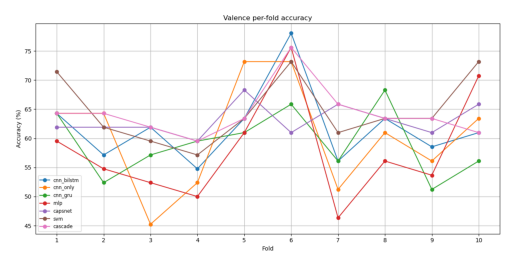

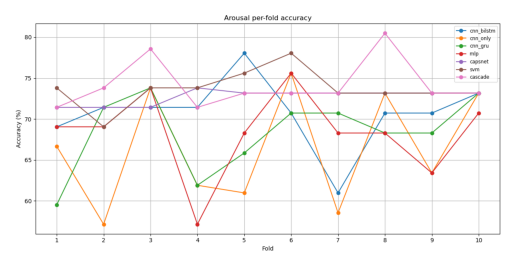

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("benchmark_results/valence_acc_plot.png")
plt.imshow(img); plt.axis('off'); plt.show()

img = mpimg.imread("benchmark_results/arousal_acc_plot.png")
plt.imshow(img); plt.axis('off'); plt.show()


In [28]:
"""
Combined benchmark script — ordered table output.
Models (order): SVM, CNN, CNN-BiLSTM, CNN-RNN, MLP, CapsNet, Cascade Forest
Outputs:
  - benchmark_results/results_table_ordered.csv
  - benchmark_results/valence_acc_plot.png
  - benchmark_results/arousal_acc_plot.png
"""

import os
import numpy as np
import random
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ---------- DEVICE ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# ---------- Shared dataset + augmentations ----------
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = np.asarray(X, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor(self.y[idx]).float()

class EEGDatasetMLP(Dataset):
    def __init__(self, X_flat, y):
        self.X = np.asarray(X_flat, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor(self.y[idx]).float()

def spec_augment(X, time_mask_width=4, n_time_masks=2, freq_mask_width=6, n_freq_masks=2):
    X_aug = X.copy()
    N, C, F, T = X_aug.shape
    for i in range(N):
        for _ in range(n_time_masks):
            w = np.random.randint(1, time_mask_width + 1)
            if w >= T: continue
            t0 = np.random.randint(0, T - w + 1)
            X_aug[i, :, :, t0:t0 + w] = 0.0
        for _ in range(n_freq_masks):
            w = np.random.randint(1, freq_mask_width + 1)
            if w >= F: continue
            f0 = np.random.randint(0, F - w + 1)
            X_aug[i, :, f0:f0 + w, :] = 0.0
    return X_aug

def add_noise(X, std=0.03):
    noise = np.random.normal(0, std, X.shape).astype(np.float32)
    return np.clip(X + noise, -3.0, 3.0)

# ---------- Models ----------
class EEG_CNN_BiLSTM(nn.Module):
    def __init__(self, n_channels=14, hidden_size=64):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), nn.Dropout(0.25),
        )
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=2,
                            batch_first=True, bidirectional=True, dropout=0.3)
        self.fc = nn.Sequential(
            nn.LayerNorm(2*hidden_size),
            nn.Linear(2*hidden_size, 64), nn.ReLU(inplace=True), nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        x = self.cnn(x)
        x = x.mean(dim=2)
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        h_cat = torch.cat((h_n[-2], h_n[-1]), dim=1)
        return self.fc(h_cat).squeeze(-1)

class EEG_CNN_only(nn.Module):
    def __init__(self, n_channels=14, hidden_feat=128):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, hidden_feat, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_feat), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1)), nn.Dropout(0.3),
        )
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_feat),
            nn.Linear(hidden_feat, hidden_feat//2), nn.ReLU(inplace=True), nn.Dropout(0.3),
            nn.Linear(hidden_feat//2, 1)
        )
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x).squeeze(-1)

class EEG_CNN_GRU(nn.Module):
    def __init__(self, n_channels=14, feat=128, rnn_hidden=64, rnn_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), nn.Dropout(0.25),
            nn.Conv2d(128, feat, kernel_size=3, padding=1), nn.BatchNorm2d(feat), nn.ReLU(inplace=True),
        )
        self.gru = nn.GRU(input_size=feat, hidden_size=rnn_hidden, num_layers=rnn_layers,
                          batch_first=True, bidirectional=False, dropout=dropout if rnn_layers>1 else 0.0)
        self.fc = nn.Sequential(
            nn.LayerNorm(rnn_hidden),
            nn.Linear(rnn_hidden, rnn_hidden//2), nn.ReLU(inplace=True), nn.Dropout(dropout),
            nn.Linear(rnn_hidden//2, 1)
        )
    def forward(self, x):
        x = self.cnn(x)
        x = x.mean(dim=2)
        x = x.permute(0,2,1)
        _, h_n = self.gru(x)
        h_last = h_n[-1]
        return self.fc(h_last).squeeze(-1)

class EEG_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[1024,512,256], dropout=0.3):
        super().__init__()
        layers=[]
        prev=input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev,h))
            layers.append(nn.LayerNorm(h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            prev=h
        layers.append(nn.Linear(prev,1))
        self.net=nn.Sequential(*layers)
    def forward(self,x):
        return self.net(x).squeeze(-1)

# CapsNet (compact)
def squash(s, dim=-1, epsilon=1e-9):
    squared_norm = (s**2).sum(dim=dim, keepdim=True)
    scale = squared_norm / (1.0 + squared_norm)
    v = scale * s / torch.sqrt(squared_norm + epsilon)
    return v

class PrimaryCapsules(nn.Module):
    def __init__(self, in_channels, num_capsules=8, capsule_dim=16, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, num_capsules*capsule_dim, kernel_size=kernel_size, stride=stride, padding=padding)
        self.num_capsules = num_capsules
        self.capsule_dim = capsule_dim
    def forward(self,x):
        out = self.conv(x)
        B,_,Fp,Tp = out.shape
        out = out.view(B, self.num_capsules, self.capsule_dim, Fp*Tp)
        out = out.permute(0,3,1,2).contiguous()
        B,P,NC,CD = out.shape
        out = out.view(B, P*NC, CD)
        out = squash(out, dim=-1)
        return out

class DigitCapsules(nn.Module):
    def __init__(self, num_input_caps, in_dim, num_output_caps=2, out_dim=16, routing_iters=3):
        super().__init__()
        self.num_input_caps = num_input_caps
        self.in_dim = in_dim
        self.num_output_caps = num_output_caps
        self.out_dim = out_dim
        self.routing_iters = routing_iters
        self.W = nn.Parameter(0.01*torch.randn(1, num_input_caps, num_output_caps, out_dim, in_dim))
    def forward(self,x):
        B = x.size(0)
        x = x.unsqueeze(2).unsqueeze(-1)
        W = self.W.repeat(B,1,1,1,1)
        u_hat = torch.matmul(W, x).squeeze(-1)
        b = torch.zeros(B, self.num_input_caps, self.num_output_caps, device=u_hat.device)
        for r in range(self.routing_iters):
            c = torch.softmax(b, dim=2).unsqueeze(-1)
            s = (c * u_hat).sum(dim=1)
            v = squash(s, dim=-1)
            if r < self.routing_iters-1:
                v_expanded = v.unsqueeze(1)
                a = (u_hat * v_expanded).sum(dim=-1)
                b = b + a
        return v

class EEG_CapsNet(nn.Module):
    def __init__(self, in_channels=14, n_classes=2, routing_iters=3, primary_caps_num=8, primary_caps_dim=16, digit_caps_dim=16):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels,64,kernel_size=3,padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64,128,kernel_size=3,padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.primary = PrimaryCapsules(in_channels=128, num_capsules=primary_caps_num, capsule_dim=primary_caps_dim)
        self.digit_caps_module_configured=False
        self.n_classes=n_classes
        self.digit_caps_dim=digit_caps_dim
        self.routing_iters=routing_iters
    def forward(self,x):
        out = self.conv_block(x)
        primary = self.primary(out)
        num_primary_caps = primary.size(1)
        in_dim = primary.size(2)
        if not self.digit_caps_module_configured:
            self.digitcaps = DigitCapsules(num_input_caps=num_primary_caps, in_dim=in_dim, num_output_caps=self.n_classes, out_dim=self.digit_caps_dim, routing_iters=self.routing_iters).to(x.device)
            self.digit_caps_module_configured=True
        digit_caps = self.digitcaps(primary)
        lengths = torch.norm(digit_caps, dim=-1)
        return lengths

# ---------- Cascade helpers (same as before) ----------
def fit_layer_oof_preds(X, y, estimators, n_splits=5, random_state=0):
    n_samples = X.shape[0]
    oof_preds=[]
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for est in estimators:
        oof = np.zeros(n_samples, dtype=np.float32)
        for tr, te in skf.split(np.arange(n_samples), y):
            est_clone = deepcopy(est)
            try: est_clone.random_state = random_state
            except: pass
            est_clone.fit(X[tr], y[tr])
            if hasattr(est_clone, "predict_proba"):
                p = est_clone.predict_proba(X[te])[:,1]
            else:
                if hasattr(est_clone, "decision_function"):
                    scores = est_clone.decision_function(X[te]); p = 1.0/(1.0+np.exp(-scores))
                else:
                    p = est_clone.predict(X[te])
            oof[te]=p
        oof_preds.append(oof.reshape(-1,1))
    meta_train = np.hstack(oof_preds)
    fitted=[]
    for est in estimators:
        est_clone = deepcopy(est)
        try: est_clone.random_state = random_state
        except: pass
        est_clone.fit(X,y)
        fitted.append(est_clone)
    return meta_train, fitted

def transform_with_layer(X, fitted_estimators):
    preds=[]
    for est in fitted_estimators:
        if hasattr(est, "predict_proba"):
            p = est.predict_proba(X)[:,1].reshape(-1,1)
        else:
            if hasattr(est, "decision_function"):
                scores = est.decision_function(X); p = (1.0/(1.0+np.exp(-scores))).reshape(-1,1)
            else:
                p = est.predict(X).reshape(-1,1)
        preds.append(p)
    return np.hstack(preds)

def train_cascade(X_train, y_train, X_val, y_val, base_estimators=None, max_layers=3, n_splits=5, random_state=0, early_stopping_rounds=2):
    if base_estimators is None:
        base_estimators = [RandomForestClassifier(n_estimators=100, n_jobs=-1), ExtraTreesClassifier(n_estimators=100, n_jobs=-1)]
    layers=[]; Xtr=X_train.copy(); Xv=X_val.copy()
    best_val_auc = -np.inf; no_improve=0
    for layer_idx in range(1, max_layers+1):
        print(f"--- Cascade Layer {layer_idx} ---")
        meta_tr, fitted = fit_layer_oof_preds(Xtr, y_train, base_estimators, n_splits=n_splits, random_state=random_state+layer_idx)
        meta_val = transform_with_layer(Xv, fitted)
        Xtr = np.hstack([Xtr, meta_tr]); Xv = np.hstack([Xv, meta_val])
        layers.append({'estimators': fitted})
        val_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=random_state+layer_idx)
        val_clf.fit(Xtr, y_train)
        try:
            y_val_prob = val_clf.predict_proba(Xv)[:,1]
        except:
            if hasattr(val_clf, "decision_function"):
                y_val_prob = 1.0/(1.0+np.exp(-val_clf.decision_function(Xv)))
            else:
                y_val_prob = val_clf.predict(Xv)
        val_auc = roc_auc_score(y_val, y_val_prob)
        print(f"Layer {layer_idx} validation AUC: {val_auc:.4f}")
        if val_auc > best_val_auc + 1e-4:
            best_val_auc = val_auc; no_improve=0
        else:
            no_improve += 1
            if no_improve >= early_stopping_rounds:
                print("No improvement — stopping cascade.")
                break
    return layers, Xtr, Xv

def predict_cascade(layers, X_raw):
    Xcur = X_raw.copy()
    for layer in layers:
        fitted = layer['estimators']
        meta = transform_with_layer(Xcur, fitted)
        Xcur = np.hstack([Xcur, meta])
    return Xcur

# ---------- Training functions ----------
def train_nn_one_fold(model, X_train_scaled, y_train_bin, X_val_scaled, y_val_bin, X_test_scaled, y_test_bin, epochs=70, base_seed=42, batch_size=16):
    X_train_sa = spec_augment(X_train_scaled)
    X_train_noise = add_noise(X_train_scaled)
    X_train_aug = np.concatenate([X_train_scaled, X_train_sa, X_train_noise], axis=0)
    y_train_aug = np.concatenate([y_train_bin, y_train_bin, y_train_bin], axis=0)

    train_loader = DataLoader(EEGDataset(X_train_aug, y_train_aug), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(EEGDataset(X_val_scaled, y_val_bin), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(EEGDataset(X_test_scaled, y_test_bin), batch_size=batch_size, shuffle=False)

    torch.manual_seed(base_seed); random.seed(base_seed); np.random.seed(base_seed)
    model = model.to(DEVICE)
    class_counts = np.bincount(y_train_bin.astype(int))
    neg = class_counts[0] if len(class_counts)>0 else 1
    pos = class_counts[1] if len(class_counts)>1 else 1
    pos_weight_val = float(neg)/float(pos) if pos>0 else 1.0
    pos_weight_t = torch.tensor([pos_weight_val], dtype=torch.float32, device=DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_t)
    opt = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=20)

    best_val_acc=0.0; best_state=None; patience=18; counter=0
    for ep in range(1, epochs+1):
        model.train()
        for xb,yb in train_loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            opt.step()
        scheduler.step()
        model.eval()
        y_true_val=[]; y_prob_val=[]
        with torch.no_grad():
            for xb,yb in val_loader:
                xb = xb.to(DEVICE)
                probs = torch.sigmoid(model(xb)).cpu().numpy()
                y_true_val.extend(yb.numpy()); y_prob_val.extend(probs)
        y_true_val = np.array(y_true_val); y_prob_val = np.array(y_prob_val)
        y_pred_val = (y_prob_val >= 0.5).astype(int)
        val_acc = accuracy_score(y_true_val, y_pred_val)
        if val_acc > best_val_acc:
            best_val_acc = val_acc; best_state = model.state_dict(); counter=0
        else:
            counter += 1
            if ep > 30 and counter >= patience: break

    if best_state is not None: model.load_state_dict(best_state)
    model.eval()
    y_true_test=[]; y_prob_test=[]
    with torch.no_grad():
        for xb,yb in test_loader:
            xb = xb.to(DEVICE)
            probs = torch.sigmoid(model(xb)).cpu().numpy()
            y_true_test.extend(yb.numpy()); y_prob_test.extend(probs)
    y_true_test = np.array(y_true_test); y_prob_test = np.array(y_prob_test)
    best_thr=0.5; best_acc=0.0
    for thr in np.linspace(0.1,0.9,17):
        yp = (y_prob_test >= thr).astype(int)
        acc_thr = accuracy_score(y_true_test, yp)
        if acc_thr > best_acc: best_acc=acc_thr; best_thr=thr
    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_true_test, y_pred_best)
    test_f1 = f1_score(y_true_test, y_pred_best)
    try: test_auc = roc_auc_score(y_true_test, y_prob_test)
    except: test_auc = float("nan")
    return test_acc, test_f1, test_auc

def train_capsnet_one_fold(model, X_train_scaled, y_train_bin, X_val_scaled, y_val_bin, X_test_scaled, y_test_bin, epochs=70, base_seed=42, batch_size=16):
    X_train_sa = spec_augment(X_train_scaled)
    X_train_noise = add_noise(X_train_scaled)
    X_train_aug = np.concatenate([X_train_scaled, X_train_sa, X_train_noise], axis=0)
    y_train_aug = np.concatenate([y_train_bin, y_train_bin, y_train_bin], axis=0)

    train_loader = DataLoader(EEGDataset(X_train_aug, y_train_aug), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(EEGDataset(X_val_scaled, y_val_bin), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(EEGDataset(X_test_scaled, y_test_bin), batch_size=batch_size, shuffle=False)

    torch.manual_seed(base_seed); random.seed(base_seed); np.random.seed(base_seed)
    model = model.to(DEVICE)
    class_counts = np.bincount(y_train_bin.astype(int))
    neg = class_counts[0] if len(class_counts)>0 else 1
    pos = class_counts[1] if len(class_counts)>1 else 1
    pos_weight_val = float(neg)/float(pos) if pos>0 else 1.0
    pos_weight_t = torch.tensor([pos_weight_val], dtype=torch.float32, device=DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_t)
    opt = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=20)

    best_val_acc=0.0; best_state=None; patience=18; counter=0
    for ep in range(1, epochs+1):
        model.train()
        for xb,yb in train_loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            lengths = model(xb)
            logits_pos = lengths[:,1].unsqueeze(1)
            loss = criterion(logits_pos, yb.unsqueeze(1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            opt.step()
        scheduler.step()
        model.eval()
        y_true_val=[]; y_prob_val=[]
        with torch.no_grad():
            for xb,yb in val_loader:
                xb = xb.to(DEVICE)
                lengths = model(xb)
                probs_pos = torch.sigmoid(lengths[:,1]).cpu().numpy()
                y_true_val.extend(yb.numpy()); y_prob_val.extend(probs_pos)
        y_true_val = np.array(y_true_val); y_prob_val = np.array(y_prob_val)
        y_pred_val = (y_prob_val >= 0.5).astype(int)
        val_acc = accuracy_score(y_true_val, y_pred_val)
        if val_acc > best_val_acc:
            best_val_acc = val_acc; best_state = model.state_dict(); counter=0
        else:
            counter += 1
            if ep > 30 and counter >= patience: break

    if best_state is not None: model.load_state_dict(best_state)
    model.eval()
    y_true_test=[]; y_prob_test=[]
    with torch.no_grad():
        for xb,yb in test_loader:
            xb = xb.to(DEVICE)
            lengths = model(xb)
            probs_pos = torch.sigmoid(lengths[:,1]).cpu().numpy()
            y_true_test.extend(yb.numpy()); y_prob_test.extend(probs_pos)
    y_true_test = np.array(y_true_test); y_prob_test = np.array(y_prob_test)
    best_thr=0.5; best_acc=0.0
    for thr in np.linspace(0.1,0.9,17):
        yp = (y_prob_test >= thr).astype(int)
        acc_thr = accuracy_score(y_true_test, yp)
        if acc_thr > best_acc: best_acc=acc_thr; best_thr=thr
    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_true_test, y_pred_best)
    test_f1 = f1_score(y_true_test, y_pred_best)
    try: test_auc = roc_auc_score(y_true_test, y_prob_test)
    except: test_auc = float("nan")
    return test_acc, test_f1, test_auc

def train_mlp_one_fold(X_train_aug_flat, y_train_aug, X_val_flat, y_val_bin, X_test_flat, y_test_bin, input_dim, epochs=70, base_seed=42, batch_size=32):
    train_loader = DataLoader(EEGDatasetMLP(X_train_aug_flat, y_train_aug), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(EEGDatasetMLP(X_val_flat, y_val_bin), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(EEGDatasetMLP(X_test_flat, y_test_bin), batch_size=batch_size, shuffle=False)

    torch.manual_seed(base_seed); random.seed(base_seed); np.random.seed(base_seed)
    model = EEG_MLP(input_dim=input_dim, hidden_dims=[1024,512,256], dropout=0.3).to(DEVICE)
    class_counts = np.bincount(y_train_aug.astype(int))
    neg = class_counts[0] if len(class_counts)>0 else 1
    pos = class_counts[1] if len(class_counts)>1 else 1
    pos_weight_val = float(neg)/float(pos) if pos>0 else 1.0
    pos_weight_t = torch.tensor([pos_weight_val], dtype=torch.float32, device=DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_t)
    opt = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=20)

    best_val_acc=0.0; best_state=None; patience=18; counter=0
    for ep in range(1, epochs+1):
        model.train()
        for xb,yb in train_loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            opt.step()
        scheduler.step()
        model.eval()
        y_true_val=[]; y_prob_val=[]
        with torch.no_grad():
            for xb,yb in val_loader:
                xb = xb.to(DEVICE)
                probs = torch.sigmoid(model(xb)).cpu().numpy()
                y_true_val.extend(yb.numpy()); y_prob_val.extend(probs)
        y_true_val=np.array(y_true_val); y_prob_val=np.array(y_prob_val)
        y_pred_val = (y_prob_val >= 0.5).astype(int)
        val_acc = accuracy_score(y_true_val, y_pred_val)
        if val_acc > best_val_acc:
            best_val_acc = val_acc; best_state = model.state_dict(); counter=0
        else:
            counter += 1
            if ep > 30 and counter >= patience: break

    if best_state is not None: model.load_state_dict(best_state)
    model.eval()
    y_true_test=[]; y_prob_test=[]
    with torch.no_grad():
        for xb,yb in test_loader:
            xb = xb.to(DEVICE)
            probs = torch.sigmoid(model(xb)).cpu().numpy()
            y_true_test.extend(yb.numpy()); y_prob_test.extend(probs)
    y_true_test=np.array(y_true_test); y_prob_test=np.array(y_prob_test)
    best_thr=0.5; best_acc=0.0
    for thr in np.linspace(0.1,0.9,17):
        yp = (y_prob_test >= thr).astype(int)
        acc_thr = accuracy_score(y_true_test, yp)
        if acc_thr > best_acc: best_acc=acc_thr; best_thr=thr
    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_true_test, y_pred_best)
    test_f1 = f1_score(y_true_test, y_pred_best)
    try: test_auc = roc_auc_score(y_true_test, y_prob_test)
    except: test_auc = float("nan")
    return test_acc, test_f1, test_auc

def train_svm_one_fold(X_train_aug_flat, y_train_aug, X_val_flat, y_val_bin, X_test_flat, y_test_bin, base_seed=42):
    classes = np.unique(y_train_aug)
    cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_aug)
    class_weight_dict = {int(c): float(w) for c,w in zip(classes,cw)}
    clf = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight=class_weight_dict, probability=True, random_state=base_seed)
    clf.fit(X_train_aug_flat, y_train_aug)
    y_prob_test = clf.predict_proba(X_test_flat)[:,1]
    best_thr=0.5; best_acc=0.0
    for thr in np.linspace(0.1,0.9,17):
        yp = (y_prob_test >= thr).astype(int)
        acc_thr = accuracy_score(y_test_bin, yp)
        if acc_thr > best_acc: best_acc=acc_thr; best_thr=thr
    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_test_bin, y_pred_best)
    test_f1 = f1_score(y_test_bin, y_pred_best)
    try: test_auc = roc_auc_score(y_test_bin, y_prob_test)
    except: test_auc = float("nan")
    return test_acc, test_f1, test_auc

def train_cascade_one_fold(X_train_aug_flat, y_train_aug, X_val_flat, y_val_bin, X_test_flat, y_test_bin, base_seed=42, max_layers=3):
    base_estimators = [RandomForestClassifier(n_estimators=100, n_jobs=-1), ExtraTreesClassifier(n_estimators=100, n_jobs=-1)]
    layers, Xtr_trans, Xval_trans = train_cascade(X_train_aug_flat, y_train_aug, X_val_flat, y_val_bin, base_estimators=base_estimators, max_layers=max_layers, n_splits=5, random_state=base_seed, early_stopping_rounds=2)
    final_clf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=base_seed)
    final_clf.fit(Xtr_trans, y_train_aug)
    X_test_trans = predict_cascade(layers, X_test_flat)
    if hasattr(final_clf, "predict_proba"):
        y_prob_test = final_clf.predict_proba(X_test_trans)[:,1]
    else:
        if hasattr(final_clf, "decision_function"):
            y_prob_test = 1.0/(1.0+np.exp(-final_clf.decision_function(X_test_trans)))
        else:
            y_prob_test = final_clf.predict(X_test_trans)
    best_thr=0.5; best_acc=0.0
    for thr in np.linspace(0.1,0.9,17):
        yp = (y_prob_test >= thr).astype(int)
        acc_thr = accuracy_score(y_test_bin, yp)
        if acc_thr > best_acc: best_acc=acc_thr; best_thr=thr
    y_pred_best = (y_prob_test >= best_thr).astype(int)
    test_acc = accuracy_score(y_test_bin, y_pred_best)
    test_f1 = f1_score(y_test_bin, y_pred_best)
    try: test_auc = roc_auc_score(y_test_bin, y_prob_test)
    except: test_auc = float("nan")
    return test_acc, test_f1, test_auc

# ---------- CV runner ----------
def run_10fold_for_model(X, y_cont, model_type="cnn_bilstm", epochs=70, base_seed=42, batch_size=16, max_layers=3):
    print(f"\nRunning 10-fold CV for model: {model_type}")
    X = np.nan_to_num(X)
    y_cont = np.asarray(y_cont, dtype=float)
    global_thr = np.median(y_cont)
    y_bin_global = (y_cont >= global_thr).astype(int)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=base_seed)

    fold_accs=[]; fold_f1s=[]; fold_aucs=[]
    for fold, (trainval_idx, test_idx) in enumerate(skf.split(np.arange(len(y_cont)), y_bin_global), start=1):
        print(f"\nFold {fold}")
        y_trainval = y_cont[trainval_idx]
        y_trainval_bin = (y_trainval >= np.median(y_trainval)).astype(int)
        test_size = len(test_idx)
        val_frac = test_size / len(trainval_idx)
        tv_train_idx, tv_val_idx = train_test_split(trainval_idx, test_size=val_frac, random_state=base_seed+fold, shuffle=True, stratify=y_trainval_bin)

        X_train = X[tv_train_idx]; X_val = X[tv_val_idx]; X_test = X[test_idx]
        y_train_cont = y_cont[tv_train_idx]; y_val_cont = y_cont[tv_val_idx]; y_test_cont = y_cont[test_idx]

        thr = np.median(y_train_cont)
        y_train_bin = (y_train_cont >= thr).astype(int)
        y_val_bin = (y_val_cont >= thr).astype(int)
        y_test_bin = (y_test_cont >= thr).astype(int)

        scaler = StandardScaler()
        X_train_flat = X_train.reshape(len(tv_train_idx), -1)
        scaler.fit(X_train_flat)
        def transform_block(X_block):
            flat = X_block.reshape(X_block.shape[0], -1)
            flat_scaled = scaler.transform(flat)
            return flat_scaled.reshape(X_block.shape)
        X_train_scaled = transform_block(X_train)
        X_val_scaled = transform_block(X_val)
        X_test_scaled = transform_block(X_test)

        if model_type == "cnn_bilstm":
            model = EEG_CNN_BiLSTM(n_channels=X.shape[1], hidden_size=64)
            acc,f1,auc = train_nn_one_fold(model, X_train_scaled, y_train_bin, X_val_scaled, y_val_bin, X_test_scaled, y_test_bin, epochs=epochs, base_seed=base_seed+fold, batch_size=batch_size)
        elif model_type == "cnn_only":
            model = EEG_CNN_only(n_channels=X.shape[1], hidden_feat=128)
            acc,f1,auc = train_nn_one_fold(model, X_train_scaled, y_train_bin, X_val_scaled, y_val_bin, X_test_scaled, y_test_bin, epochs=epochs, base_seed=base_seed+fold, batch_size=batch_size)
        elif model_type == "cnn_gru":
            model = EEG_CNN_GRU(n_channels=X.shape[1], feat=128, rnn_hidden=64, rnn_layers=2)
            acc,f1,auc = train_nn_one_fold(model, X_train_scaled, y_train_bin, X_val_scaled, y_val_bin, X_test_scaled, y_test_bin, epochs=epochs, base_seed=base_seed+fold, batch_size=batch_size)
        elif model_type == "mlp":
            X_train_flat = X_train_scaled.reshape(len(tv_train_idx), -1)
            X_val_flat = X_val_scaled.reshape(len(tv_val_idx), -1)
            X_test_flat = X_test_scaled.reshape(len(test_idx), -1)
            X_train_sa = spec_augment(X_train_scaled)
            X_train_noise = add_noise(X_train_scaled)
            X_train_sa_flat = X_train_sa.reshape(X_train_sa.shape[0], -1)
            X_train_noise_flat = X_train_noise.reshape(X_train_noise.shape[0], -1)
            X_train_aug_flat = np.concatenate([X_train_flat, X_train_sa_flat, X_train_noise_flat], axis=0)
            y_train_aug = np.concatenate([y_train_bin, y_train_bin, y_train_bin], axis=0)
            input_dim = X_train_aug_flat.shape[1]
            acc,f1,auc = train_mlp_one_fold(X_train_aug_flat, y_train_aug, X_val_flat, y_val_bin, X_test_flat, y_test_bin, input_dim=input_dim, epochs=epochs, base_seed=base_seed+fold, batch_size=32)
        elif model_type == "capsnet":
            model = EEG_CapsNet(in_channels=X.shape[1], n_classes=2, routing_iters=3, primary_caps_num=8, primary_caps_dim=16, digit_caps_dim=16)
            acc,f1,auc = train_capsnet_one_fold(model, X_train_scaled, y_train_bin, X_val_scaled, y_val_bin, X_test_scaled, y_test_bin, epochs=epochs, base_seed=base_seed+fold, batch_size=batch_size)
        elif model_type == "svm":
            X_train_flat = X_train_scaled.reshape(len(tv_train_idx), -1)
            X_val_flat = X_val_scaled.reshape(len(tv_val_idx), -1)
            X_test_flat = X_test_scaled.reshape(len(test_idx), -1)
            X_train_sa = spec_augment(X_train_scaled)
            X_train_noise = add_noise(X_train_scaled)
            X_train_sa_flat = X_train_sa.reshape(X_train_sa.shape[0], -1)
            X_train_noise_flat = X_train_noise.reshape(X_train_noise.shape[0], -1)
            X_train_aug_flat = np.concatenate([X_train_flat, X_train_sa_flat, X_train_noise_flat], axis=0)
            y_train_aug = np.concatenate([y_train_bin, y_train_bin, y_train_bin], axis=0)
            acc,f1,auc = train_svm_one_fold(X_train_aug_flat, y_train_aug, X_val_flat, y_val_bin, X_test_flat, y_test_bin, base_seed=base_seed+fold)
        elif model_type == "cascade":
            X_train_flat = X_train_scaled.reshape(len(tv_train_idx), -1)
            X_val_flat = X_val_scaled.reshape(len(tv_val_idx), -1)
            X_test_flat = X_test_scaled.reshape(len(test_idx), -1)
            X_train_sa = spec_augment(X_train_scaled)
            X_train_noise = add_noise(X_train_scaled)
            X_train_sa_flat = X_train_sa.reshape(X_train_sa.shape[0], -1)
            X_train_noise_flat = X_train_noise.reshape(X_train_noise.shape[0], -1)
            X_train_aug_flat = np.concatenate([X_train_flat, X_train_sa_flat, X_train_noise_flat], axis=0)
            y_train_aug = np.concatenate([y_train_bin, y_train_bin, y_train_bin], axis=0)
            acc,f1,auc = train_cascade_one_fold(X_train_aug_flat, y_train_aug, X_val_flat, y_val_bin, X_test_flat, y_test_bin, base_seed=base_seed+fold, max_layers=max_layers)
        else:
            raise ValueError("Unknown model type")
        fold_accs.append(acc); fold_f1s.append(f1); fold_aucs.append(auc)
        print(f"Fold {fold} -> Acc={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

    return np.array(fold_accs), np.array(fold_f1s), np.array(fold_aucs)

# ---------- Master benchmark (ordered output) ----------
def benchmark_all_models_ordered(X, y_val, y_aro, epochs=20, base_seed=42, outdir="benchmark_results"):
    os.makedirs(outdir, exist_ok=True)

    # Desired order & mapping to internal model_type keys
    ordered_models = [
        ("SVM", "svm"),
        ("CNN", "cnn_only"),
        ("CNN-BiLSTM", "cnn_bilstm"),
        ("CNN-RNN", "cnn_gru"),
        ("MLP", "mlp"),
        ("CapsNet", "capsnet"),
        ("Cascade Forest", "cascade"),
    ]

    results_rows = []
    per_model_fold_accs = {}

    for display_name, key in ordered_models:
        print("\n" + "="*50 + f"\nRunning model: {display_name} ({key})")
        val_accs, val_f1s, val_aucs = run_10fold_for_model(X, y_val, model_type=key, epochs=epochs, base_seed=base_seed, batch_size=16)
        aro_accs, aro_f1s, aro_aucs = run_10fold_for_model(X, y_aro, model_type=key, epochs=epochs, base_seed=base_seed+100, batch_size=16)
        # Format "mean ± std" in percent with 2 decimals
        val_mean = val_accs.mean()*100; val_std = val_accs.std()*100
        aro_mean = aro_accs.mean()*100; aro_std = aro_accs.std()*100
        val_formatted = f"{val_mean:.2f}% ± {val_std:.2f}%"
        aro_formatted = f"{aro_mean:.2f}% ± {aro_std:.2f}%"
        results_rows.append({
            "Model": display_name,
            "Valence Acc ± std": val_formatted,
            "Arousal Acc ± std": aro_formatted,
            "valence_acc_mean": val_accs.mean(), "valence_acc_std": val_accs.std(),
            "arousal_acc_mean": aro_accs.mean(), "arousal_acc_std": aro_accs.std(),
        })
        per_model_fold_accs[display_name] = {"valence": val_accs, "arousal": aro_accs}

    # Build DataFrame with requested two columns first
    df_ordered = pd.DataFrame(results_rows)[["Model", "Valence Acc ± std", "Arousal Acc ± std",
                                             "valence_acc_mean","valence_acc_std","arousal_acc_mean","arousal_acc_std"]]
    csv_path = os.path.join(outdir, "results_table_ordered.csv")
    df_ordered.to_csv(csv_path, index=False)
    print("\nSaved ordered results table to:", csv_path)
    # Print just the concise requested table (first two columns)
    print("\n===== Summary table  =====")
    print(df_ordered[["Model","Valence Acc ± std","Arousal Acc ± std"]])

    # Plots (per-fold accuracy)
    folds = np.arange(1, 11)
    plt.figure(figsize=(12,6))
    for name in per_model_fold_accs:
        plt.plot(folds, per_model_fold_accs[name]["valence"]*100, marker='o', label=name)
    plt.xticks(folds); plt.xlabel("Fold"); plt.ylabel("Accuracy (%)")
    plt.title("Valence 10 Fold Cross Validation"); plt.legend(fontsize='small'); plt.grid(True); plt.tight_layout()
    vpng = os.path.join(outdir, "valence_acc_plot.png"); plt.savefig(vpng); plt.close()
    print("Saved", vpng)

    plt.figure(figsize=(12,6))
    for name in per_model_fold_accs:
        plt.plot(folds, per_model_fold_accs[name]["arousal"]*100, marker='o', label=name)
    plt.xticks(folds); plt.xlabel("Fold"); plt.ylabel("Accuracy (%)")
    plt.title("Arousal 10 Fold Cross Validation"); plt.legend(fontsize='small'); plt.grid(True); plt.tight_layout()
    apng = os.path.join(outdir, "arousal_acc_plot.png"); plt.savefig(apng); plt.close()
    print("Saved", apng)

    return df_ordered, per_model_fold_accs, csv_path, vpng, apng

# ---------- Run (requires X, y_val, y_aro loaded) ----------
if __name__ == "__main__":
    try:
        X; y_val; y_aro
    except NameError:
        raise RuntimeError("Please prepare variables X, y_val, y_aro before running this script.")
    # run benchmark (epochs default 20 for speed; increase if needed)
    df_ordered, per_fold, csv_path, vplot, aplot = benchmark_all_models_ordered(X, y_val, y_aro, epochs=20, base_seed=42, outdir="benchmark_results")
    print("\nAll done. Ordered results saved to:", csv_path)
    print("Valence plot path:", vplot)
    print("Arousal plot path:", aplot)


DEVICE: cuda

Running model: SVM (svm)

Running 10-fold CV for model: svm

Fold 1
Fold 1 -> Acc=0.6905, F1=0.7937, AUC=0.6130

Fold 2
Fold 2 -> Acc=0.6190, F1=0.7500, AUC=0.4952

Fold 3
Fold 3 -> Acc=0.6667, F1=0.7742, AUC=0.5505

Fold 4
Fold 4 -> Acc=0.5476, F1=0.7077, AUC=0.4447

Fold 5
Fold 5 -> Acc=0.6098, F1=0.7419, AUC=0.5950

Fold 6
Fold 6 -> Acc=0.7317, F1=0.8070, AUC=0.7675

Fold 7
Fold 7 -> Acc=0.6098, F1=0.7576, AUC=0.4025

Fold 8
Fold 8 -> Acc=0.6341, F1=0.7692, AUC=0.5850

Fold 9
Fold 9 -> Acc=0.6098, F1=0.7576, AUC=0.4175

Fold 10
Fold 10 -> Acc=0.7561, F1=0.8214, AUC=0.6900

Running 10-fold CV for model: svm

Fold 1
Fold 1 -> Acc=0.7143, F1=0.8333, AUC=0.4861

Fold 2
Fold 2 -> Acc=0.6905, F1=0.8169, AUC=0.5889

Fold 3
Fold 3 -> Acc=0.7619, F1=0.8387, AUC=0.8056

Fold 4
Fold 4 -> Acc=0.7381, F1=0.8451, AUC=0.5833

Fold 5
Fold 5 -> Acc=0.7561, F1=0.8571, AUC=0.6000

Fold 6
Fold 6 -> Acc=0.7805, F1=0.8657, AUC=0.5970

Fold 7
Fold 7 -> Acc=0.7317, F1=0.8451, AUC=0.6303

Fold